# Exploring the UTx000 Extension Beacon Data
(See the [GH repo](https://github.com/intelligent-environments-lab/utx000))

In [1]:
import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

# Estimating Ventilation Rates
Using CO$_2$, we can estimate the ventilation rates in the space using various methodologies. 

This notebook uses the `ventilation.py` source code included in this project. This script includes a superclass `calculate` with two child subclasses `steady_state` and `decay` which estimate the vnetilation rate with those two methods, repsectively. 

## Package Import

In [2]:
import os
import sys
sys.path.append('../')

from src.visualization import visualize
from src.analysis import ventilation
from src.analysis import occupancy_detection

import pandas as pd
pd.set_option('display.max_columns', 200)
import numpy as np

from datetime import datetime, timedelta

import math
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

from sklearn.neural_network import MLPClassifier

---

<a id="toc"></a>

# Table of Contents

1. [Data Notes](#data)
2. [Analysis Notes](#analysis)
3. [Steady-State](#steady_state)
    1. [Evening Data](#ss_evening)
    2. [Model-Detected Data](#ss_occ)
    3. [Comparing SS Estimates](#ss_comparisons)
4. [Dynamic](#dynamic)
    1. [Build-Up](#buildup)
    2. [Decay](#decay)
5. [Combining and Saving Rates](#saving)
6. [Inspecting Rates](#inspecting)
    1. [Steady-State](#ss_inspection)
    2. [Build-Up](#buildup_inspection)
    3. [Decay](#decay_inspection)
5. [Sensitivity Analysis](#sensitivity_analysis)
    1. [Steady-State](#ss_sa)
    2. [Build-Up](#buildup_sa)
    3. [Decay](#decay_sa)
8. [General Summary](#summary)

---

<a id="data"></a>

# Notes on Data Used
The necesary data are imported when insantiating a `calculate` object. 

## Beacon Data
We are primarily concerned with the beacon data when participants are asleep since that is the only time we can be sure participants are home in their bedrooms. However, we also need all the processed beacon since the methods in the `decay` class utilize measurements made after the occupant has awakened. Therefore, we have three datasets from the beacon measurements:

1. **All**: All the IAQ measurements made by the beacons indexed by the timestamp.
2. **Nightly Measurements**: IAQ Measurements made by the beacons during Fitbit identified sleep events which have also been cross-referenced with GPS data to confirm participants are in the same location as the beacon during sleep events.
3. **"Morning" Measurements**: IAQ measurements made by the beacons a _certain_ period after participants have awakened. These periods are not necessarily confined to morning hours since some participants had non-traditional sleep schedules and the period can be toggled to whatever hour.

## Participant Information
We need the participant beacon, beiwe, and fitbit IDs so we can cross-reference the various pieces of information. This dataset contains other information including the sex of the individual and the estimated volume of their bedrooms (depends on the dwelling type). 

## Fitbit Data
Beacon data have already been parsed out according to Fitbit-detected sleep events. The only time we need Fitbit data is for the weight that participants included when _originally_ signing up for an account since the estimated respiration rate depends on the boddy mass of the participant. 

[Back to ToC](#toc)

---

<a id="steady_state"></a>

[Back to ToC](#toc)
# Ventilation based on constant CO2 concentration
We can estimate the ventilation rate of the participants' bedrooms based on a constant CO2 concentration:

$$
\lambda = \frac{E}{V \left(C - pC_0\right)}
$$

In our case we have to make quite a few assumptions:
- [$E$](#e): Emission rate of CO2 can be estimated for humans to be approximately $30 g/hr$. We can further refine this value by considering the height, weight, sex, and activity level of the participant - all information that we have access to. 
- [$V$](#V): Arguably the most difficult value to track down and the one that could affect the answer the most. We can assume a volume of each of the participants bedrooms, but there is the possiblility of refining this value by cross-referencing the participants' addresses with any known apartment complexes. From there, we can estimate the floor plan based on the number of roommates.
- $p$: Penetration factor of background CO2 from into the space - we can safely assume this to be 1.
- [$C_0$](#background_co2): Background CO2 concentration. While 400 - 450 ppm is the typical assumption, using this value seems to result in very low ventilation rates.

The subsequent sections dive a bit deeper into each of the parameters.

In [15]:
ss_calc = ventilation.steady_state(data_dir="../data")

<a id="emission_rate_discussion"></a>

## Emission Rate
Based on an article that Sangeetha sent me, we can determine the emission rate of CO2 from the following equation:

$$
V_{CO_2} = (BMR)(M)(T/P)(0.000179)
$$

where:
- $V_{CO_2}$ is the volumetric emission rate of CO2 in L/s
- $BMR$ is the body mass ratio determined from Persily and De Jonge 2016
- $M$: Activity level in METs
- $T$ is the temperature in Kelvin
- $P$ is the pressure in kPa

### Body Mass Ratio
The body mass ratio is given by one of the two equations since our participants are in the age range of 18-30

$$
BMR_{male} = 0.063m + 2.896\\
BMR_{female} = 0.062m + 2.036
$$

where $m$ is the body mass in kilograms. We have the pariticpants body weights assuming they logged them into Fitbit. We can grab these data and put it alongside the participants beacon, beiwe, and fitbit IDs. We take the body weight for each participant, average it over the total amount of time logged (just in case they changed it which I doubt anyone did) and store that value.

Then we calculate the BMR based on the mass and sex of the participants

### Activity Level in METs
The Persily and De Jong 2016 article gives values for activity level in METs dependingon the activity. We can assume that our participants are asleep since we are only using data when Fitbit detects sleeping individuals. The MET value for a sleeping individual, from the article, is **0.95**.

### Temperature and Pressure
The **temperature will vary depending on the night** that we choose to analyze and therefore will alter the emission rate of CO2. Thus we have to account for the temperature.

The pressure will more or less remain constant since we are at the same altitude for the most part in Austin. The National Weather Service has a [station at the airport](https://w1.weather.gov/data/obhistory/KAUS.html) in Austin that reports the atmopsheric pressure is around **102.5 kPa**.

<a id="V"></a>

## Volume
We can always assume a value for the volume of the space, or we can go a bit more in-depth by looking at the addresses of the participants.

Doing this presents their own set of problems since we now have to trust the answers of the participants and the addresses could be different than the addresess we sent the beacons to. Rather, we can simply use average numbers:
- **Stand-Alone Home**: We can use the US average of 11x12 feet with 9 foot ceilings - **1188 feet**
- **Apartment**: Another average value would be 10x12 with 9 foot ceilings - **1080 feet**

<div class="alert-block alert alert-success">
The volumes have been added to the info.csv file for each participant based on the address used to ship the beacons to.
<div>

### Estimating volume based on CO2 growth

<div class="alert-block alert alert-danger">
The results from this analysis were never used since the volumes they returned were erroneous.
<div>

While not a good estimate, we can use periods of uniterrupted CO2 concentration increases to estimate what the volume of the space might be. Under these conditions, we might assume the the contribution from outdoors is negligible and we simply have accumulation:

$$
V \frac{dC}{dt} = E
$$

We can rearrange the original equation to solve for the volume.

In [4]:
volume_estimate = ventilation.calculate(data_dir="../data")

In [5]:
v_estimates = volume_estimate.estimate_volume_from_co2(volume_estimate.beacon_nightly,volume_estimate.info)
v_estimates

,beacon,starting_co2,co2_delta,ending_co2,R^2,volume_est,volume_gen
beiwe,,,,,,,
745vq78e,5.0,1456.543595,124.669770,1581.213365,0.993354,4370.344932,1188.0
9jtzsuu8,15.0,1190.336830,126.249838,1316.586668,0.995697,4068.524845,1188.0
awa8uces,26.0,1285.889838,39.119771,1325.009609,0.993907,4084.202987,1188.0
e73a1pd5,16.0,3555.177007,303.247405,3858.424412,0.994127,1517.619360,1080.0
i31pt4b4,11.0,2179.054785,90.084338,2269.139123,0.994632,5325.167339,1080.0
idbkjh8u,30.0,1118.820121,33.434277,1152.254398,0.990073,8869.013855,1080.0
kyj367pi,1.0,714.155082,45.950021,760.105103,0.994741,8133.603137,1080.0
lkkjddam,21.0,1083.115538,162.259918,1245.375456,0.994288,5265.675741,1188.0
nvtfpaor,46.0,1281.463238,60.081855,1341.545093,0.994106,4614.148257,1188.0


<a id="background_co2"></a>

## Background CO2
We have two options for the background CO$_2$ concentration, both of which introduce their own set of problems.

* **Constant Value**: we can assume the background CO2 concentration is ~450 ppm for each participant which is likely true for the outdoor conditions, but might not be a fair assumption since CO$_2$ concentrations might be, on average, higher in the household.
* **Participant-Based Value**: we can use participant-specific data to estimate a background concentration by using a lower-percentile concentration or the minimum. This process results in vastly different background concentrations but is likely more realistic. 

## Constant CO2
Now we need to find periods during the evening when the CO2 concentration is constant. We can do this by looking at the mean difference in CO2 concentration during a certain window. If the change is less than a certain threshold, we can then assume the concentration is stable.

We can also cross-reference with the temperature to make sure that the AC isn't just cycling on and off quickly keeping the CO2 within a tight window. 

## Air Exchange Rate
Now we have all the information we need for the equation, we can determine the air exchange rate in each of the participants' homes.

We do need to find some extra information to convert our units:
- **Density of CO2 ($\rho_{CO_2}$)**: The density of CO2 can be found [here](www.engineeringtoolbox.com/carbon-dioxide-density-specific-weight-temperature-pressure-d_2018.html). We want to look for nearly atmospheric pressure and room temperature.
- **Conversions**: Like cubic feet to cubic meters, ppm to g/m$^3$, and the like.

<a id="ss_evening"></a>

## Emission Rates from Evening IAQ Data

<div class="alert-block alert alert-info">
    
We are using the _minimum_ CO2 concentration for the background value
    
<div>

In [6]:
estimates_ss = ss_calc.ventilation_ss(ss_calc.beacon_nightly,ss_calc.info,constant_c0=False,c0_percentile=0,
                                      min_co2_threshold=None,co2_threshold_percentile=50,plot=False)

### Summary

#### Ventilation Rates

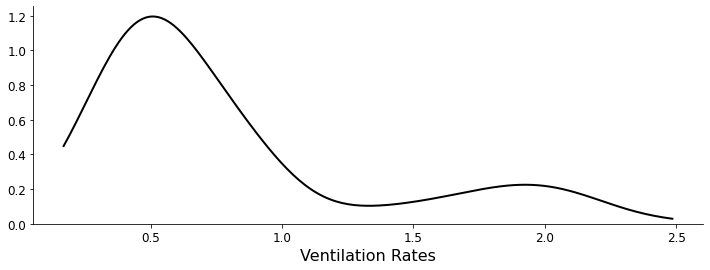

count    242.000000
mean       0.798963
std        0.547036
min        0.168227
25%        0.435305
50%        0.577018
75%        0.876062
max        2.485909
Name: ach, dtype: float64


In [7]:
ss_calc.summarize_estimates(estimates_ss)

#### CO2 Emission Rates

In [8]:
print(np.nanmin(estimates_ss["e"])*3600, "L/h")
print(np.nanmean(estimates_ss["e"])*3600, "L/h")
print(np.nanmax(estimates_ss["e"])*3600, "L/h")

8.88240274595198 L/h
10.876672529251135 L/h
14.639849883585953 L/h


<a id="ss_occ"></a>

## Steady-State Estimates from Occupancy Detection Data
We have a subset of data that we were able to get from doing occupancy detection using co2 and tvoc data that we can try to get steady-state estimates from.

### Occupancy Detection Model

In [9]:
process_data = occupancy_detection.PreProcess(data_dir="../data",features=["co2","tvoc"])
process_data.run()
model = occupancy_detection.Classify(labeled_data=process_data.data,all_data=process_data.beacon_all,features=["co2","tvoc"])
model.classify(model=MLPClassifier,
          model_params={"hidden_layer_sizes":(16,64),"activation":"relu","solver":"lbfgs","max_iter":20000},
          observations=model.get_unlabeled_data(), target="bedroom")


Starting...

	Creating Pipeline
	Fitting Model to Labeled Data
	Classifying Occupancy on Unlabeled Data

Done - Time for Evaluation: 5.34 seconds
Starting...

	Creating Pipeline
	Fitting Model to Labeled Data
	Classifying Occupancy on Unlabeled Data

Done - Time for Evaluation: 8.83 seconds
Starting...

	Creating Pipeline
	Fitting Model to Labeled Data
	Classifying Occupancy on Unlabeled Data

Done - Time for Evaluation: 43.34 seconds
Starting...

	Creating Pipeline
	Fitting Model to Labeled Data
	Classifying Occupancy on Unlabeled Data

Done - Time for Evaluation: 18.46 seconds
Starting...

	Creating Pipeline
	Fitting Model to Labeled Data
	Classifying Occupancy on Unlabeled Data

Done - Time for Evaluation: 2.28 seconds
Starting...

	Creating Pipeline
	Fitting Model to Labeled Data
	Classifying Occupancy on Unlabeled Data

Done - Time for Evaluation: 22.66 seconds
Starting...

	Creating Pipeline
	Fitting Model to Labeled Data
	Classifying Occupancy on Unlabeled Data

Done - Time for 

### Getting ventilation rates for different confidence levels
Takes a good while to run

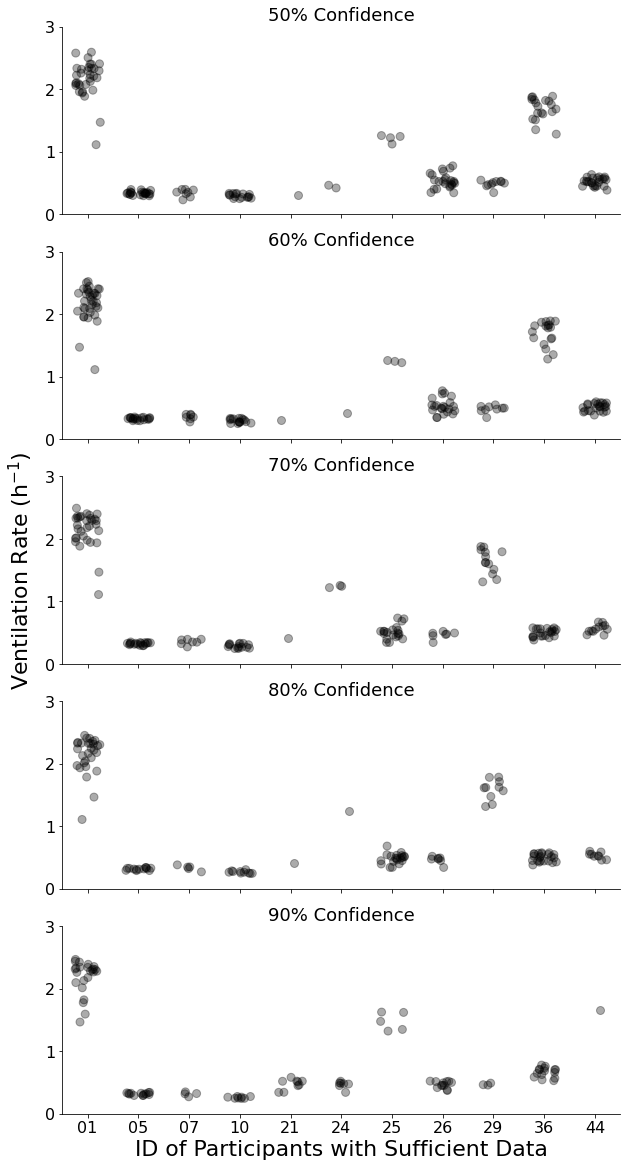

In [86]:
estimates_occ = ss_calc.get_occupancy_detection_rates(model,percents=[0.5,0.6,0.7,0.8,0.9],plot=True,save=False,)

The issue we have is that ventilation rates calculated from the same period for >70% might not be the same for >80% or higher because there might be data at the beginning and ending of the periods from >70% that are not included in >80% because they no longer pass the confidence threshold. So rather than saying that >70% provides additional periods over more strict confidence levels, it does this in addition to changing the ventilation estimates.

<div class="alert-block alert alert-warning">

While the above figures are _correct_ to include _all_ ventilation rates from the periods, the figures doesn't provide too much information. Better to just keep things in a table to save space as well.
<div>

### Plotting and Tabulating

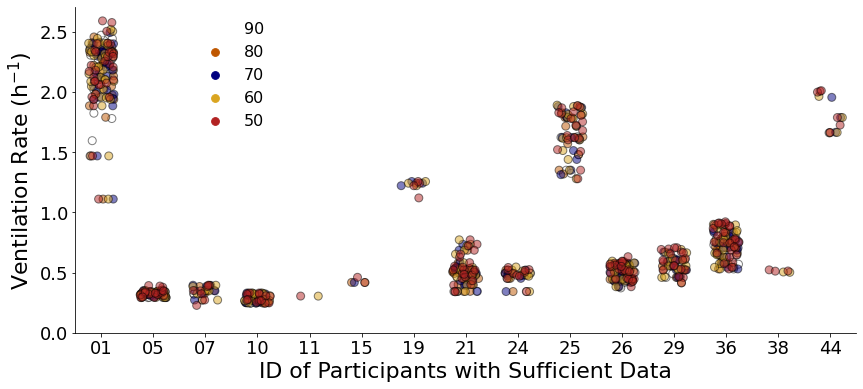

In [87]:
ventilation.plot_strip(estimates_occ,save=False)

In [88]:
ventilation.tabulate_estimates(estimates_occ)

\begin{tabular}{lrrrrrrrr}
\toprule
{} &  Number &  Number Of Participants &   Min &   25\% &  Median &   75\% &   90\% &  Mean \\
Method    &         &                         &       &       &         &       &       &       \\
\midrule
50        &     223 &                      15 &  0.23 &  0.42 &    0.58 &  1.31 &  2.08 &  0.91 \\
60        &     201 &                      15 &  0.25 &  0.42 &    0.57 &  1.51 &  2.15 &  0.93 \\
70        &     172 &                      13 &  0.25 &  0.39 &    0.55 &  1.45 &  2.18 &  0.90 \\
80        &     147 &                      13 &  0.25 &  0.43 &    0.54 &  1.41 &  2.23 &  0.90 \\
90        &     101 &                      11 &  0.25 &  0.34 &    0.52 &  1.60 &  2.31 &  0.93 \\
Aggregate &     844 &                      15 &  0.23 &  0.40 &    0.55 &  1.47 &  2.20 &  0.91 \\
\bottomrule
\end{tabular}



,Number,Number Of Participants,Min,25%,Median,75%,90%,Mean
Method,,,,,,,,
50,223,15,0.23,0.42,0.58,1.31,2.08,0.91
60,201,15,0.25,0.42,0.57,1.51,2.15,0.93
70,172,13,0.25,0.39,0.55,1.45,2.18,0.90
80,147,13,0.25,0.43,0.54,1.41,2.23,0.90
90,101,11,0.25,0.34,0.52,1.60,2.31,0.93
Aggregate,844,15,0.23,0.40,0.55,1.47,2.20,0.91


Estimates seem to be on par with each other regardless of the occupancy confidence. That is likely a function of including the good estimates with the bad whereas if we were to compare 60-70% confidence to >90% confidence, we would see significant differences. Might be an interesting thing to check out. 

<a id="ss_comparison"></a>

## Comparing Steady-State Estimates Across Datasets
How do the ventilation rates from the evening data stack up against those estimated from periods identified by the model?

In [89]:
# adding in night_time measurements
estimates_ss_temp = estimates_ss.copy()
estimates_ss_temp["method"] = "Evening"
estimates_ss_agg = estimates_occ.append(estimates_ss_temp)

### t-Tests on Distributions from All Methods
Mann-Whitney unpaired t-Test on the means

In [90]:
for method1 in estimates_ss_agg["method"].unique():
    for method2 in estimates_ss_agg["method"].unique():
        if method1 == method2:
            continue
        else:
            ach1 = estimates_ss_agg[estimates_ss_agg["method"] == method1]["ach"]
            ach2 = estimates_ss_agg[estimates_ss_agg["method"] == method2]["ach"]
            t, p = ventilation.perform_t_test(ach1,ach2,equal_var=False)
            print(f"{method1} vs {method2}: {round(p,3)}")
            
    print()

50 vs 60: 0.737
50 vs 70: 0.966
50 vs 80: 0.894
50 vs 90: 0.815
50 vs Evening: 0.063

60 vs 50: 0.737
60 vs 70: 0.727
60 vs 80: 0.672
60 vs 90: 0.985
60 vs Evening: 0.034

70 vs 50: 0.966
70 vs 60: 0.727
70 vs 80: 0.931
70 vs 90: 0.799
70 vs Evening: 0.107

80 vs 50: 0.894
80 vs 60: 0.672
80 vs 70: 0.931
80 vs 90: 0.75
80 vs Evening: 0.157

90 vs 50: 0.815
90 vs 60: 0.985
90 vs 70: 0.799
90 vs 80: 0.75
90 vs Evening: 0.132

Evening vs 50: 0.063
Evening vs 60: 0.034
Evening vs 70: 0.107
Evening vs 80: 0.157
Evening vs 90: 0.132



### Evening vs 90% Confidence Rates
The most apt comparison.

In [15]:
# getting just the 90% confidence rates
estimates_occ_90 = estimates_ss_agg[estimates_ss_agg["method"] == "90"]
estimates_occ_90["method"] = "occupancy_detection"

In [16]:
estimates_ss_temp = estimates_ss.copy()
estimates_ss_temp["method"] = "evening_data"
combined = pd.concat([estimates_ss_temp,estimates_occ_90])

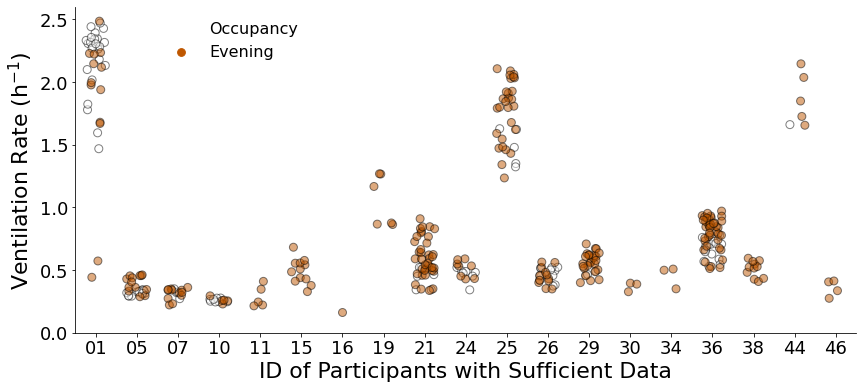

In [17]:
ventilation.plot_strip(combined,annot="-ss_only",sort_order=[True,False],conduct_ttest=False,save=False)


#### Aggregate Basis
Probably not the appropriate method, but still worthwhile

In [18]:
# testing the means
_, p = ventilation.perform_t_test(estimates_ss["ach"],estimates_occ_90["ach"])
print("Aggregated Evening vs 90% Confidence (means):", round(p,3))

Aggregated Evening vs 90% Confidence (means): 0.083


In [19]:
# testing the medians
_, p = ventilation.perform_kruskal_test(estimates_ss["ach"],estimates_occ_90["ach"])
print("Aggregated Evening vs 90% Confidence (medians):", round(p,3))

Aggregated Evening vs 90% Confidence (medians): 0.449


<div class="alert-block alert alert-success">

There are no significant differences between the mean and median ventilation rates from the two datasets.
<div>

#### Per Participant

In [76]:
for pt in sorted(estimates_occ_90["beacon"].unique()):
    night_pt = estimates_ss[estimates_ss["beacon"] == pt]
    occ_pt = estimates_occ_90[estimates_occ_90["beacon"] == pt]
    # getting number of data points
    print(pt)
    print(f"\tNight:\tMean:{round(np.mean(night_pt['ach']),2)}\tMin:{round(np.min(night_pt['ach']),2)}\tMedian:{round(np.median(night_pt['ach']),2)}\tMax:{round(np.max(night_pt['ach']),2)}\tN:{len(night_pt)}")
    print(f"\t90%:\tMean:{round(np.mean(occ_pt['ach']),2)}\tMin:{round(np.min(occ_pt['ach']),2)}\tMedian:{round(np.median(occ_pt['ach']),2)}\tMax:{round(np.max(occ_pt['ach']),2)}\tN:{len(occ_pt)}")
    if len(night_pt) >= 10 and len(occ_pt) >= 10:
        _, p_mean = ventilation.perform_t_test(night_pt["ach"],occ_pt["ach"])
        _, p_median = ventilation.perform_kruskal_test(night_pt["ach"],occ_pt["ach"])
        print("\tt-Test:\t",round(p_mean,3))
        print("\tKruskal:",round(p_median,3))

1.0
	Night:	Mean:1.82	Min:0.44	Median:2.0	Max:2.49	N:13
	90%:	Mean:2.19	Min:1.47	Median:2.29	Max:2.47	N:24
	t-Test:	 0.018
	Kruskal: 0.012
5.0
	Night:	Mean:0.39	Min:0.29	Median:0.41	Max:0.46	N:13
	90%:	Mean:0.32	Min:0.29	Median:0.32	Max:0.34	N:13
	t-Test:	 0.001
	Kruskal: 0.003
7.0
	Night:	Mean:0.31	Min:0.22	Median:0.33	Max:0.36	N:12
	90%:	Mean:0.32	Min:0.27	Median:0.32	Max:0.35	N:4
10.0
	Night:	Mean:0.26	Min:0.23	Median:0.26	Max:0.29	N:5
	90%:	Mean:0.26	Min:0.25	Median:0.26	Max:0.28	N:8
21.0
	Night:	Mean:0.61	Min:0.34	Median:0.59	Max:0.91	N:37
	90%:	Mean:0.47	Min:0.34	Median:0.51	Max:0.58	N:9
24.0
	Night:	Mean:0.51	Min:0.43	Median:0.53	Max:0.59	N:8
	90%:	Mean:0.47	Min:0.34	Median:0.48	Max:0.52	N:7
25.0
	Night:	Mean:1.77	Min:1.24	Median:1.83	Max:2.11	N:28
	90%:	Mean:1.48	Min:1.32	Median:1.48	Max:1.63	N:5
26.0
	Night:	Mean:0.45	Min:0.35	Median:0.44	Max:0.56	N:12
	90%:	Mean:0.47	Min:0.37	Median:0.48	Max:0.52	N:12
	t-Test:	 0.541
	Kruskal: 0.564
29.0
	Night:	Mean:0.56	Min:0.4	Median:0.57	

<div class="alert-block alert alert-warning">

We have 12 participants who we can estimate ventilation rates from with both datasets, but only 5 participants with at least 10 estimates from each dataset. Running a t-Test and a Kruskal test on data from these 5 participants, all but one participant has significantly different mean and median values. 
<div>

[Back to Top](#steady_state)

---

<a id="dynamic"></a>

[Back to ToC](#toc)
# Ventilation Based on Dynamic Solution
We can estimate the ventilation rate of the participants' bedrooms using the dynamic solution to the CO2 mass balance:

$$
C_t = C_{t=0}e^{-\lambda t} + \left(pC_0 + \frac{E}{\lambda V}\right)\left(1 - e^{-\lambda t}\right)
$$

The benefit of this approach is that the exchange rate we get might be agnostic to the accuracy of the sensor assuming the sensor is precise (just off from the true value by a constant difference).

Many of the variables from the previous analysis show up here again which is nice since we already found those. 
- $C_t$: CO2 concentation at some time, $t$
- $C_{t=0}$: CO2 concentration at the beginning of the analysis period
- $E$: Emission rate of CO2 estimated from the Persily and Jonge (2016) paper which looks at the activity, sex, and BMR of the participant. 
- $V$: We opted for a more generic value rather than diving too deep.
- $\lambda$: air exchange rate
- $p$: Penetration factor of CO2 from outside into the indoor space - we can safely assume this to be 1.
- [$C_0$](#background_co2): Background CO2 concentration. 

There are a few things for us to consider with this approach:
1. What data do we need and from what time?
2. We can use a build-up (occupant initially enters the space) and a decay (occupant leaves after sleeping) approach.
3. How do we identify periods of CO2 build-up/decay?
4. The solution involves an iterative approach since we cannot easily solve for the air exchange rate, $\lambda$
5. What error metrics should we use to ensure we have the optimal solution?
4. What value(s) should be used for the background concentration?

In [21]:
dynamic_calc = ventilation.dynamic(data_dir="../data")

## Solution 1: Build-Up - Occupant initially enters the space
We can directly apply the above equation. If so, we have to undergo a similar process as with the constant CO2 method i.e. we need the emission rate and the volume of the space. 

## Solution 2: Decay - Occupant leaves the space after sleep event
If the participant leaves the bedroom, we don't have any emission sources. Therefore, our equation simplifies to:

$$
C_t = C_{t=0}e^{-\lambda t} + pC_0\left(1 - e^{-\lambda t}\right)
$$

However, we are now looking at a slightly different dataset. 

## Background Concentration
The analysis in [Diagnosing Decay Results](#diagnosing_decay) highlights that the assumption of a 450 ppm background concentration results in _low_ `ach` measurements. This assumption is safer for a leakier, typically unoccupied space -- such as a classroom -- but does not hold for this analysis. Rather than assume some concentration, we should use the participant-based approach.

<div class="alert-block alert alert-info">

As of right now, the methods that incorporate a background concentration are using the **0th percentile** CO$_2$ concentration per each participant. 
<div>

## Identifying periods of build-up/decay
We just need to call the function ```get_co2_periods()``` but set the ```change``` parameter to ```'increasing'``` or ```'decreasing'```, depending on the problem. A consideration of the temperature during the relevant time has been incorporated into this function to account for the AC operation.

An important consideration that was initially looked over was ensuring that we only include periods of build up and decay where the change in concentration is _significant_. We can define significant any way we want, but for the time-being, use four times the sensor's accuracy: 120 ppm.

## Iteratively solving for ventilation rate
Now that we can get the periods of increasing/decreasing CO2 concentrations, we can use the dynamic solution and continuously vary the air exchange rate until we get the lowest error between the measured and estimated concentrations at $t > 0$.

We opt for a "brute-force" method rather than something more sophisticated since the run-times are low and we have a limited range of `ach` to consider in addition to a limited accuracy threshold.

[Back to Top](#dynamic)

---

<a id="buildup"></a>

[Back to ToC](#toc)
# Build-Up
There was a substantial amount of work done to configure this method which is discussed in some detail later in [Inspecting Rates: Build-Up](#buildup_inspection). Here, I briefly describe the outcomes and what parameters were used in the final estimation and why. The source code also provides some detail regarding the default values.

* `constant_c0=False`: Using a participant-specific background CO2 concentration was more appropriate and resulted in ventialtion rates that were more reasonable. **This analysis should be highlighted in the paper's discussion**.
* `co_percentile=0`: 0th percentile i.e. the minimum values makes the most sense since that would correspond to the home's background. The [Sensitivity Anaylsis](#sa) also dives into this.
* `min_window_threshold=30`: From my previous history, a period of at least an hour is necessary for a proper ventilation rate estimate. Given that data are measured at a 2-minute resolution, this correspond to a window of at least 30 data points.
* `min_co2_threshold=600`: Doesn't make much sense for the CO2 concentration to be lower than this value if the room is occupied and the sensors are properly calibrated. One could argue even this value is too low.
* `delta_co2_threshold=120`: The change in the CO2 during the period has to be at least 4 times the sensor resolution. One might consider this value too low, but if the ventilation rate is strong enough, the CO2 concentrations might not vary _that_ much.
* `truncate_threshold=1`: This parameter corresponds to how we remove initial measurements from the increase period. Since a fair amount of the measured values follow a logit curve, we want to exclude these initial measurements that are increasing, but at a small rate. In this case, we omit initial values were the change in CO2 is less than 1 ppm. 
* `decreasing_increase=False`: We don't use the outcome from this analysis because we ended up fitting ventilation rates from only a handful of measurements. This process was another way of removing the logit form from the measured values by only including the latter measurements where the increase in CO2 starts to wane i.e. the difference between increasing measurements starts to decrease ("decreasing increase"). 
* `decreasing_increase_rate=5`: Resample rate of the final measurements to overcome issues with sensor variability. 5-minutes seemed most reasonable but this process is not used so this number is unecessary. 
* `plot=False`: No need to plot diagnostic plots at this point
* `save_plot=False`: Even less of a reason to save these figures that we aren't plotting.

In [22]:
estimates_buildup = dynamic_calc.ventilation_buildup(dynamic_calc.beacon_nightly, dynamic_calc.info,
                                                     constant_c0=False, c0_percentile=0, min_window_threshold=30, min_co2_threshold=600, delta_co2_threshold=120,
                                                     truncate_threshold=1, decreasing_increase=False, decreasing_increase_rate=5, plot=False, save_plot=False)


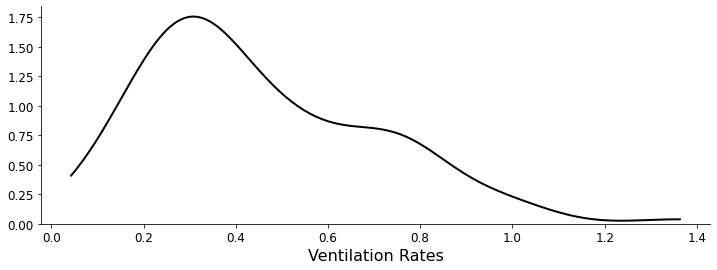

count    106.000000
mean       0.452868
std        0.251870
min        0.043000
25%        0.271750
50%        0.383000
75%        0.633500
max        1.363000
Name: ach, dtype: float64


In [23]:
dynamic_calc.summarize_estimates(estimates_buildup)

---

<a id="decay"></a>

[Back to ToC](#toc)
# Decay
Configuration for this method comes from the work done in [Inspecing Rates:Decay](#decay_inspection) which is limited in scope compared to the Build-Up diagnostic work although I use my history with those parameters to help reduce the workload on this method. Below are rationale for the parameter values which _are the same for the build-up method_:

* `constant_c0=False`: Using a participant-specific background CO2 concentration was more appropriate and resulted in ventilation rates that were more reasonable. **This analysis should be highlighted in the paper's discussion**.
* `co_percentile=0`: 0th percentile i.e. the minimum values makes the most sense since that would correspond to the home's background. The [Sensitivity Anaylsis](#sa) also dives into this.
* `min_window_threshold=30`: From my previous history, a period of at least an hour is necessary for a proper ventilation rate estimate. Given that data are measured at a 2-minute resolution, this correspond to a window of at least 30 data points.
* `min_co2_threshold=600`: Doesn't make much sense for the CO2 concentration to be lower than this value if the room is occupied and the sensors are properly calibrated. One could argue even this value is too low.
* `delta_co2_threshold=120`: The change in the CO2 during the period has to be at least 4 times the sensor resolution. One might consider this value too low, but if the ventilation rate is strong enough, the CO2 concentrations might not vary _that_ much.
* `plot=False`: No need to plot diagnostic plots at this point
* `save_plot=False`: Even less of a reason to save these figures that we aren't plotting.

## Beacon Data after Waking
We need to grab a different set of beacon data to do this assessment. Instead of looking at CO2 data during the evening, we actually need the CO2 data for a few hours right _after_ the participants woke up. We should be able to easily do this by looking at the stop times from the filtered beacon data and parsing out timestamps for the few hours after this from the processed beacon data.

In [24]:
morning_beacon_co2 = dynamic_calc.get_morning_beacon_data(dynamic_calc.beacon_nightly,dynamic_calc.beacon_all,num_hours=3)
dynamic_calc.set_beacon_morning(morning_beacon_co2)
dynamic_calc.beacon_morning.head()

,beiwe,beacon,co2,temperature_c,rh,start_time
timestamp,,,,,,
2020-07-18 12:40:00,nvtfpaor,46,1414.064060,26.792008,35.063333,2020-07-18 12:40:00
2020-07-18 12:42:00,nvtfpaor,46,1412.732789,26.792008,35.096667,2020-07-18 12:40:00
2020-07-18 12:44:00,nvtfpaor,46,1410.979668,26.792008,35.130000,2020-07-18 12:40:00
2020-07-18 12:46:00,nvtfpaor,46,1409.486384,26.792008,35.156667,2020-07-18 12:40:00
2020-07-18 12:48:00,nvtfpaor,46,1407.771363,26.792008,35.156667,2020-07-18 12:40:00


## Calculating

In [25]:
estimates_decay = dynamic_calc.ventilation_decay(dynamic_calc.beacon_morning, dynamic_calc.info,
                                                 constant_c0=False, c0_percentile=0, min_window_threshold=30, min_co2_threshold=600, delta_co2_threshold=120,
                                                 plot=False,save_plot=False)


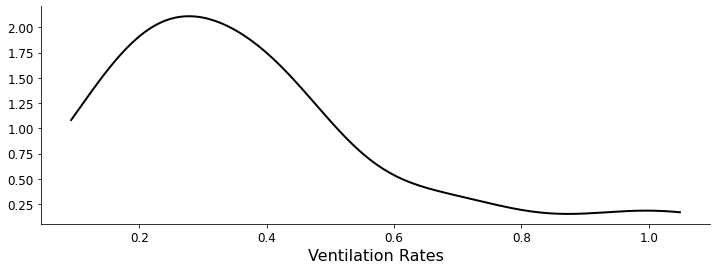

count    39.000000
mean      0.358103
std       0.214197
min       0.093000
25%       0.216000
50%       0.302000
75%       0.431500
max       1.049000
Name: ach, dtype: float64


In [26]:
dynamic_calc.summarize_estimates(estimates_decay)

---

<a id="saving"></a>

[Back to ToC](#toc)
# Saving

### Combining Estimates
Putting everything in one dataframe

In [27]:
estimates = {"ss":estimates_ss, "build-up":estimates_buildup, "decay":estimates_decay}
estimates_df = pd.DataFrame()
for key in estimates.keys():
    # adding columns to group on
    estimates[key]["method"] = key
    estimates_df = estimates_df.append(estimates[key])
    
estimates_complete = estimates_df.append(estimates_occ)

In [28]:
estimates_complete.to_csv("../data/processed/beacon-ventilation.csv",index=False)

### Steady-State

#### Evening 

In [29]:
estimates_ss.to_csv("../data/processed/beacon-ventilation_estimates-ss-ux_s20.csv",index=False)

#### Model Detected

In [30]:
estimates_occ.to_csv("../data/processed/beacon-ventilation_estimates-occ-ux_s20.csv",index=False)

### Decay

In [31]:
estimates_decay.to_csv("../data/processed/beacon-ventilation_estimates-decay-ux_s20.csv",index=False)

### Build-Up

In [32]:
estimates_buildup.to_csv("../data/processed/beacon-ventilation_estimates-buildup-ux_s20.csv",index=False)

---

<a id="comparing"></a>

[Back to ToC](#toc)
# Comparing Rates Across Methods
Now that we have calculated the ventilation rates through four methods, we can compare the results. 

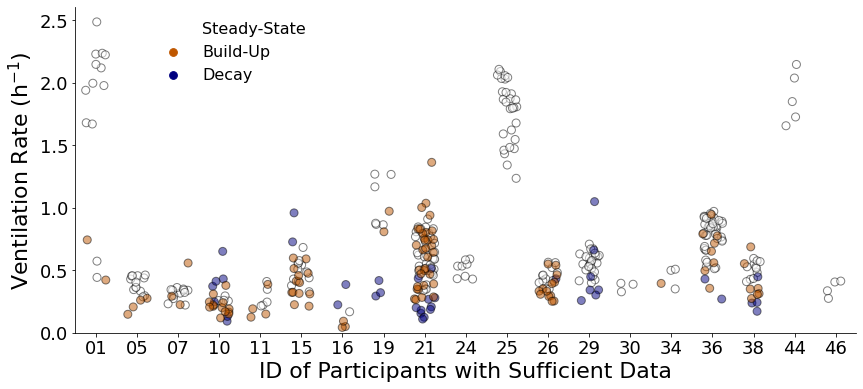

In [33]:
ventilation.plot_strip(estimates_df,save=False)

In [34]:
print("Number:", len(estimates_df))
print("Minimum:", np.nanmin(estimates_df["ach"]))
print("Minimum:", np.nanmean(estimates_df["ach"]))
print("Maximum:", np.nanmax(estimates_df["ach"]))

Number: 387
Minimum: 0.043000000000000003
Minimum: 0.6597391944725611
Maximum: 2.4859085234590768


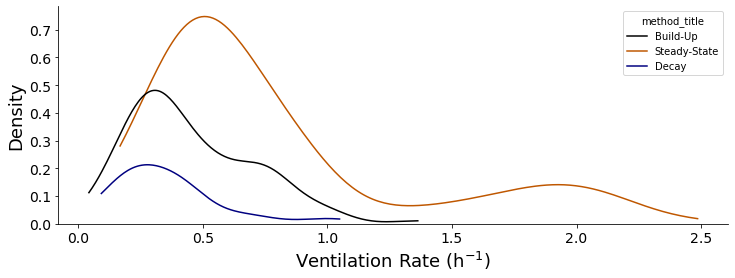

In [35]:
ventilation.plot_distribution(estimates_df)

In [36]:
ventilation.tabulate_estimates(estimates_df)

\begin{tabular}{lrrrrrrrr}
\toprule
{} &  Number &  Number Of Participants &   Min &   25\% &  Median &   75\% &   90\% &  Mean \\
Method       &         &                         &       &       &         &       &       &       \\
\midrule
Steady-State &     242 &                      19 &  0.17 &  0.44 &    0.58 &  0.88 &  1.85 &  0.80 \\
Build-Up     &     106 &                      13 &  0.04 &  0.27 &    0.38 &  0.63 &  0.80 &  0.45 \\
Decay        &      39 &                       9 &  0.09 &  0.22 &    0.30 &  0.43 &  0.65 &  0.36 \\
Aggregate    &     387 &                      19 &  0.04 &  0.35 &    0.51 &  0.78 &  1.48 &  0.66 \\
\bottomrule
\end{tabular}



,Number,Number Of Participants,Min,25%,Median,75%,90%,Mean
Method,,,,,,,,
Steady-State,242,19,0.17,0.44,0.58,0.88,1.85,0.80
Build-Up,106,13,0.04,0.27,0.38,0.63,0.80,0.45
Decay,39,9,0.09,0.22,0.30,0.43,0.65,0.36
Aggregate,387,19,0.04,0.35,0.51,0.78,1.48,0.66


---

<a id="inspecting"></a>

[Back to ToC](#toc)
# Inspecting Ventilation Estimates
There are some edge cases that could use a closer look at. This section focuses on diagnosing any issues and _hopefully_ improving the estimation process.

<a id="ss_inspection"></a>

## Steady-State

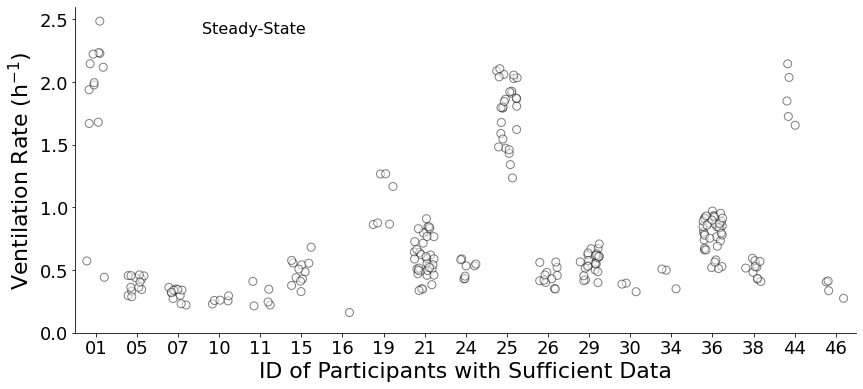

In [37]:
ventilation.plot_strip(estimates_ss)

<div class="alert-block alert alert-warning">
    
Beacons 1, 25, and 44 all have mean CO2 measurements in the mid-600s and low variability which explains why the steady-state estimates shoot up since the minimum CO2, and hence the background CO2, concentration is so high.
<div>

In [38]:
print("Number:", len(estimates_ss))
print("Minimum:", np.nanmin(estimates_ss["ach"]))
print("Minimum:", np.nanmedian(estimates_ss["ach"]))
print("Maximum:", np.nanmax(estimates_ss["ach"]))

Number: 242
Minimum: 0.1682273670354152
Minimum: 0.5770178760851906
Maximum: 2.4859085234590768


### Inspecting High Steady-State Estimates
There are a few participants with higher-than-normal rates for both estimation types:
1. Beacon 1
2. Beacon 25
3. Beacon 30 (evening data only)
3. Beacon 44

The subsections below dive into these participants:

#### Beacon 1

Study Measurements
	Min:	486.79596594171846
	Mean:	648.887582543202
	Max:	1178.4253466105135
Night Measurements
	Min:	497.5145054
	Mean:	650.0769045868848
	Max:	1177.405763
Morning Measurements


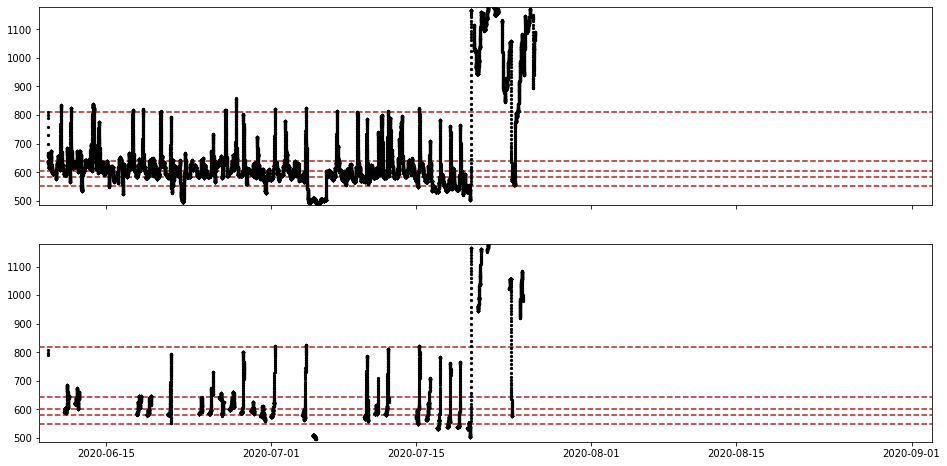

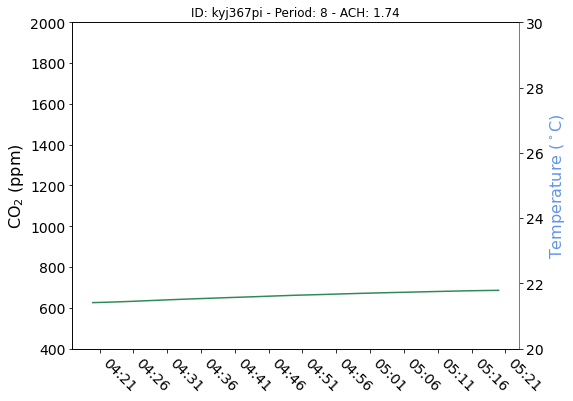

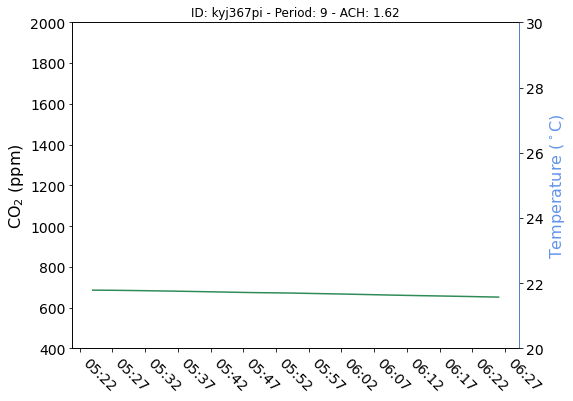

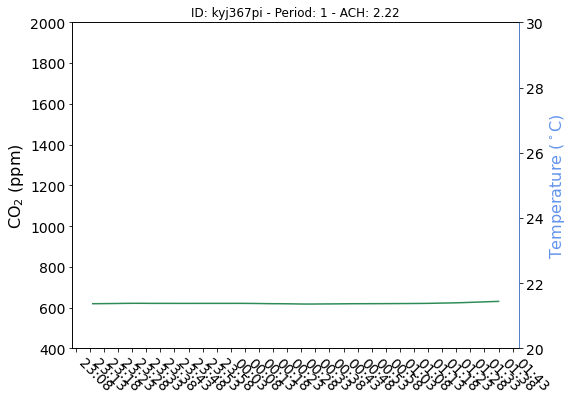

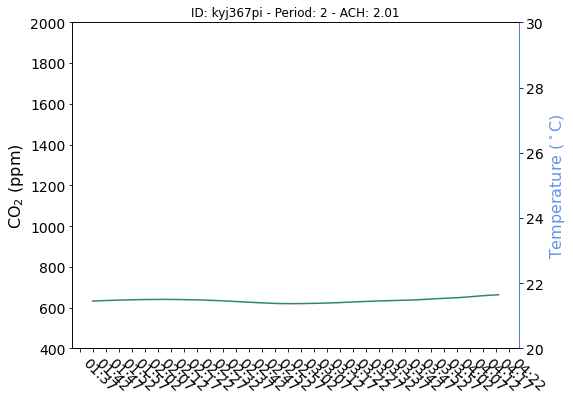

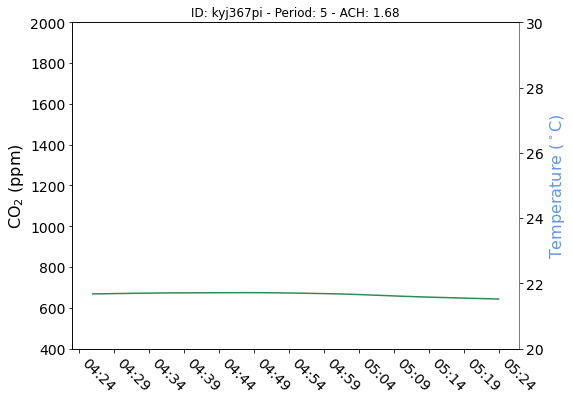

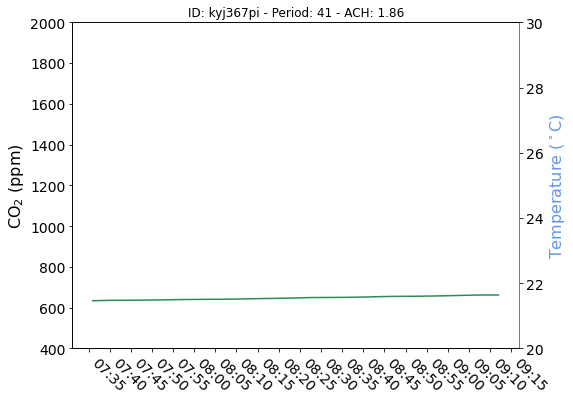

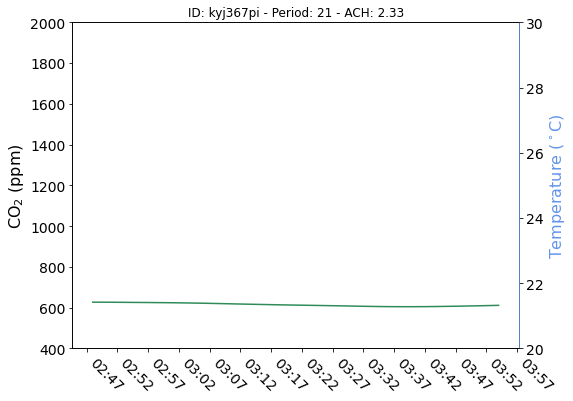

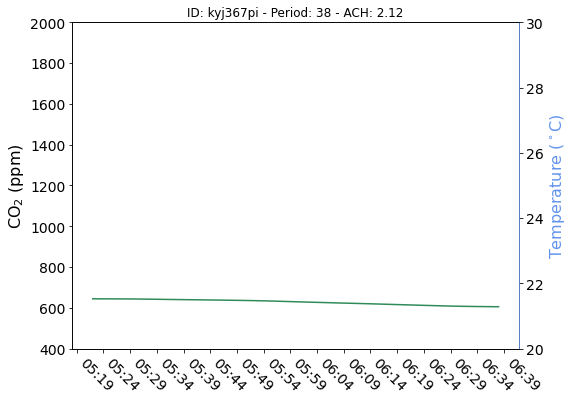

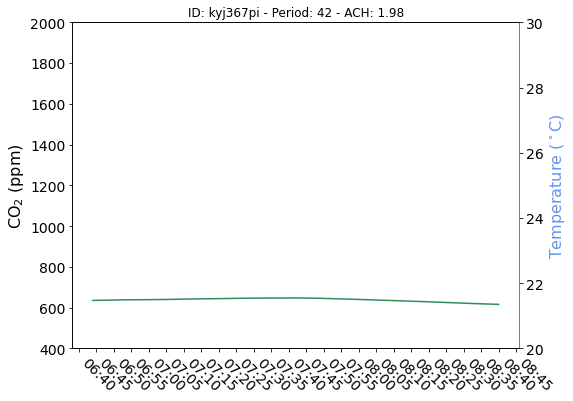

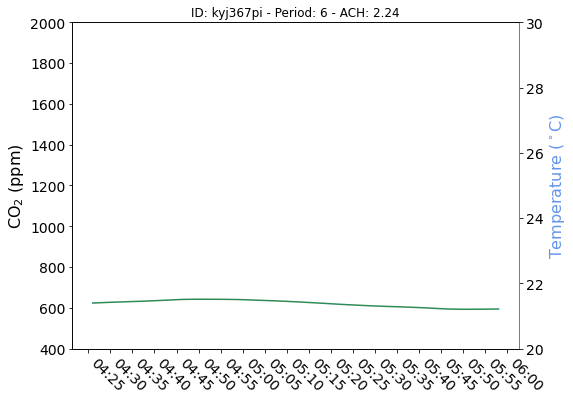

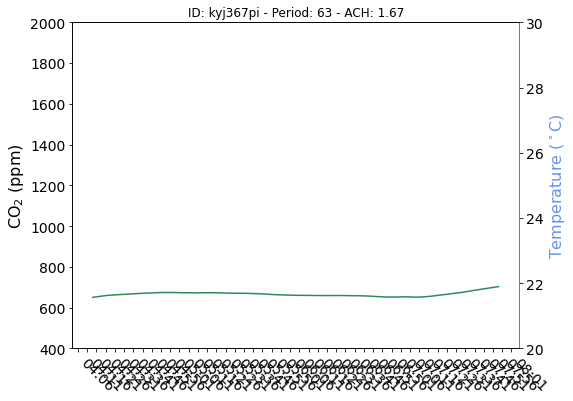

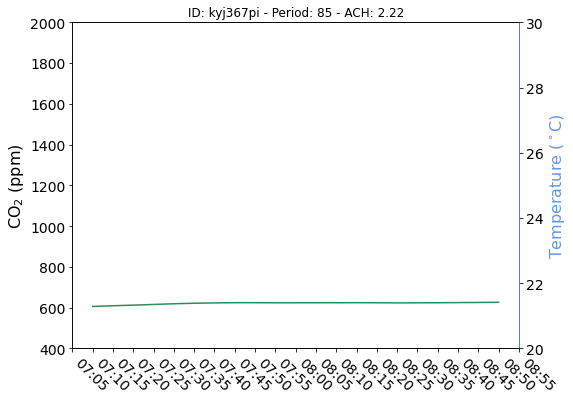

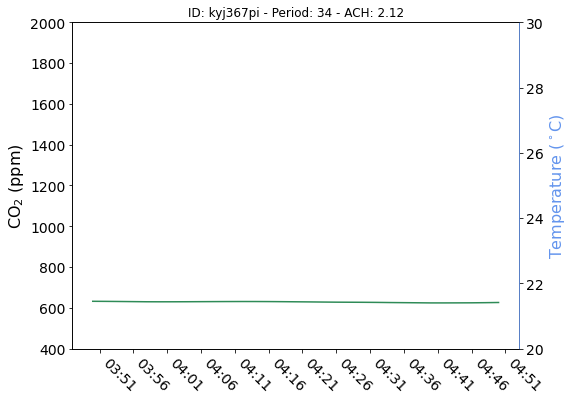

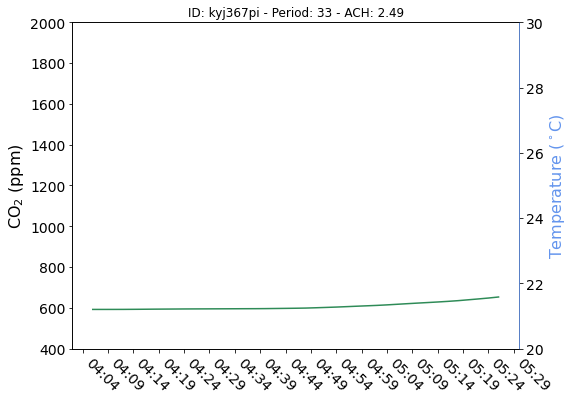

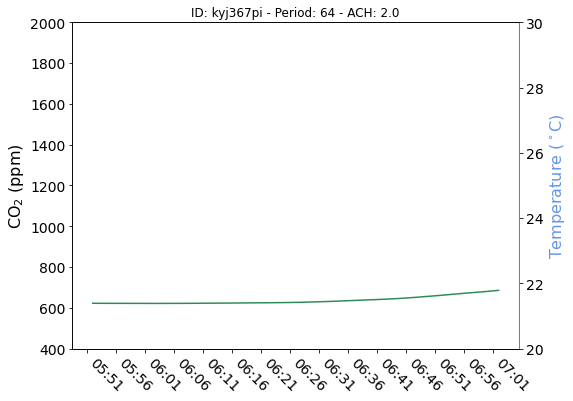

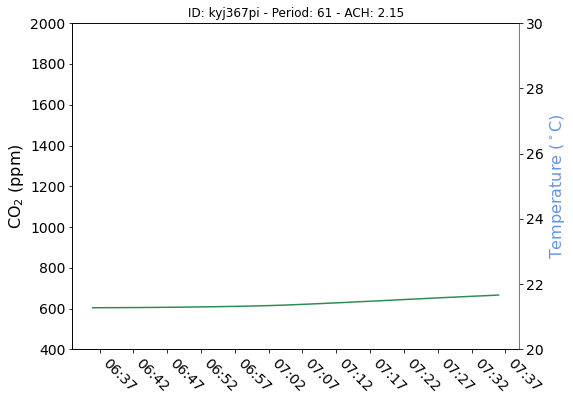

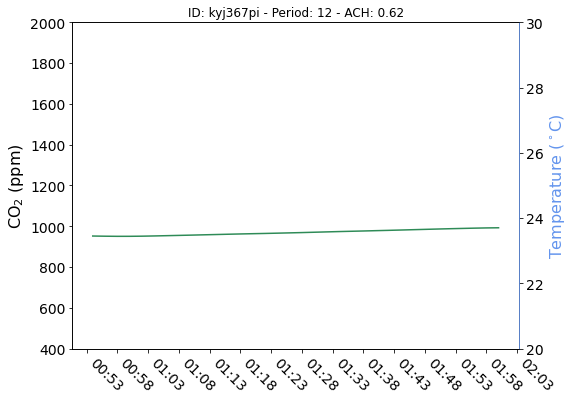

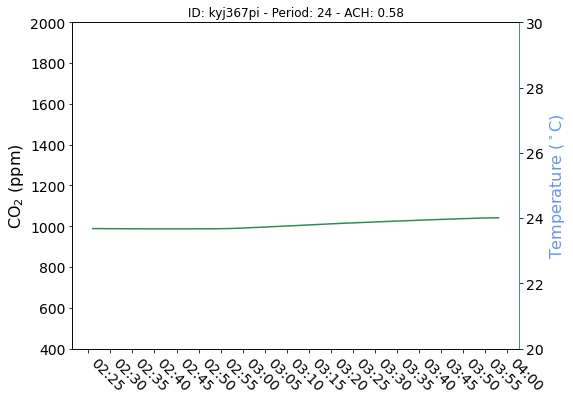

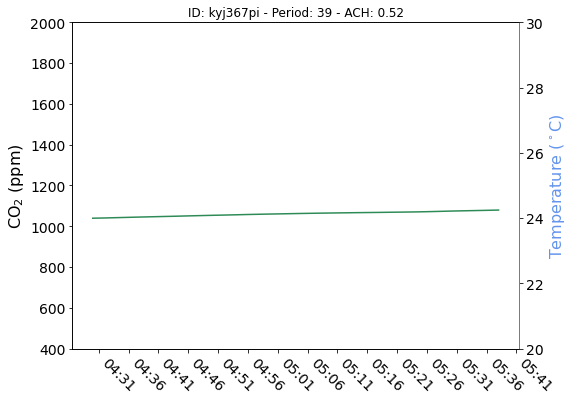

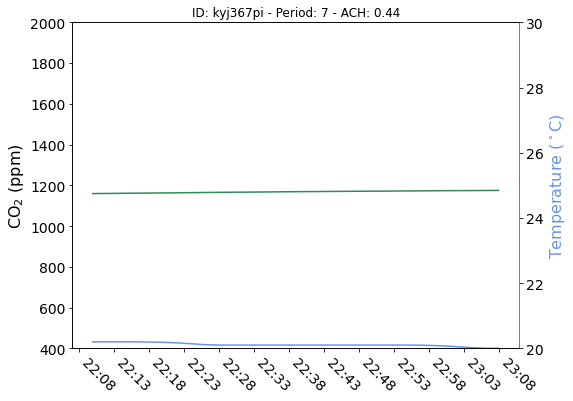

In [39]:
_ = ss_calc.diagnose_participant(1,view_ss=True)

<div class="alert-block alert alert-success">
    
We identified an issue with the way we were calculating steady-state rates. We were ensuring that conesecutive points did not vary by more than +/- 10 ppm, but we were not considering the _overall_ change in concentration. Now we limit the overall change to 60 ppm which corresponds to the +/- 30 ppm accuracy on the sensor.
<div>

#### Beacon 19
Just to compare against low decay rates (see below)

Study Measurements
	Min:	616.3420274524163
	Mean:	848.2671468988275
	Max:	1150.4405157349418
Night Measurements
	Min:	674.5543313
	Mean:	921.0589442741722
	Max:	1148.994606
Morning Measurements


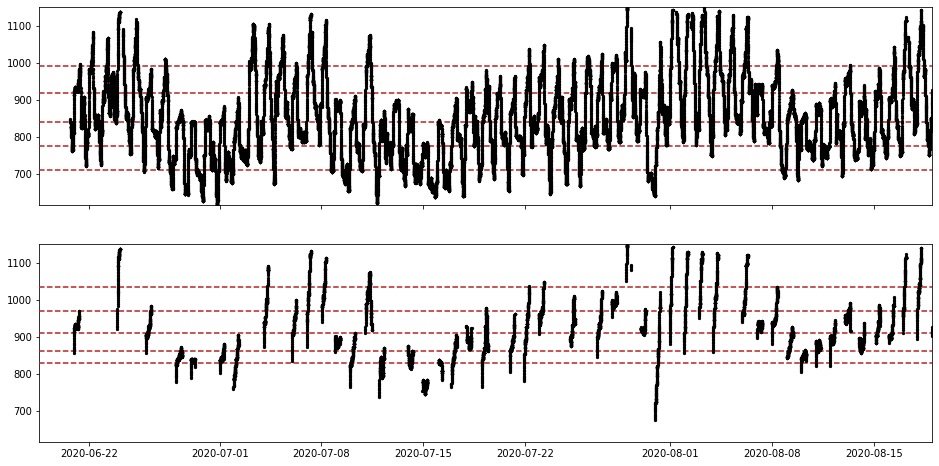

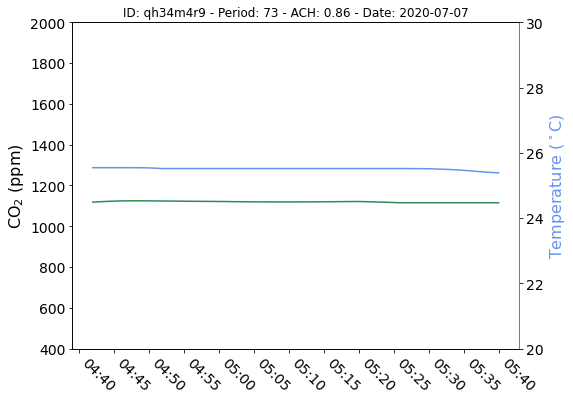

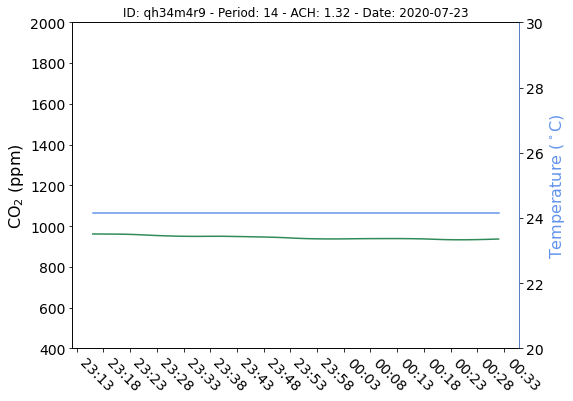

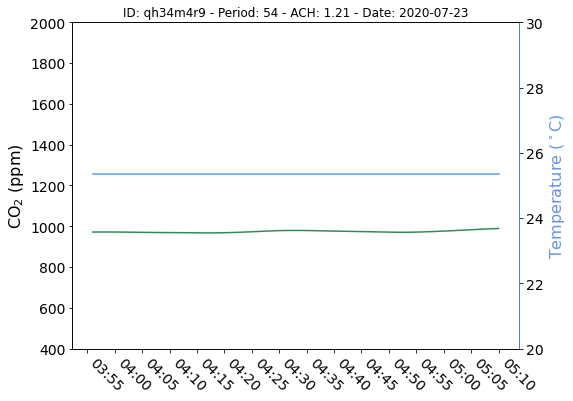

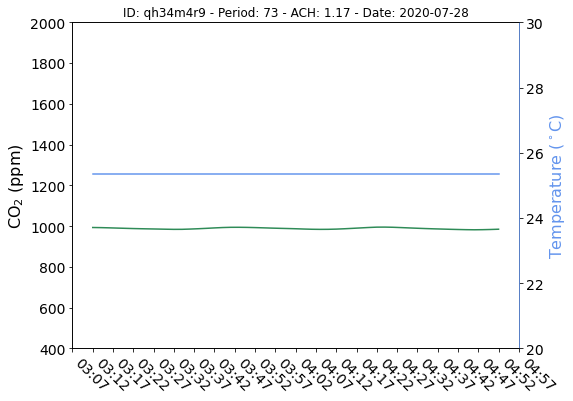

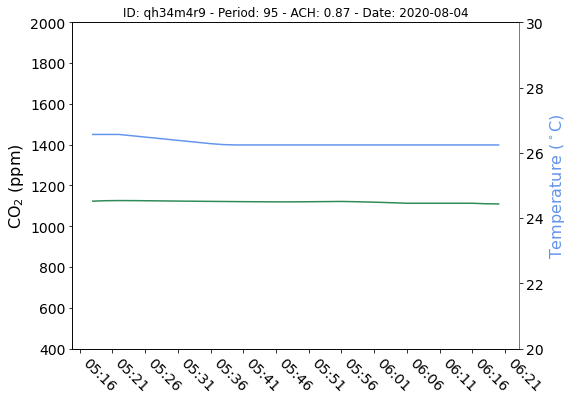

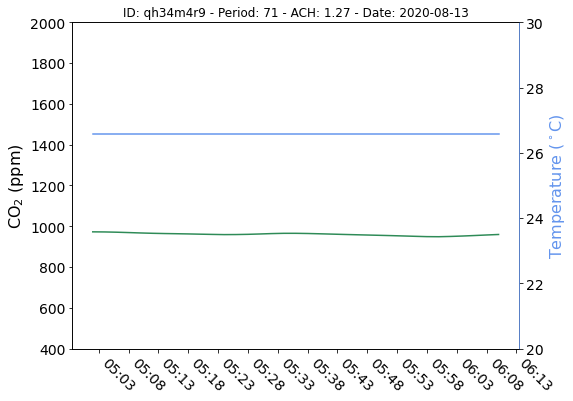

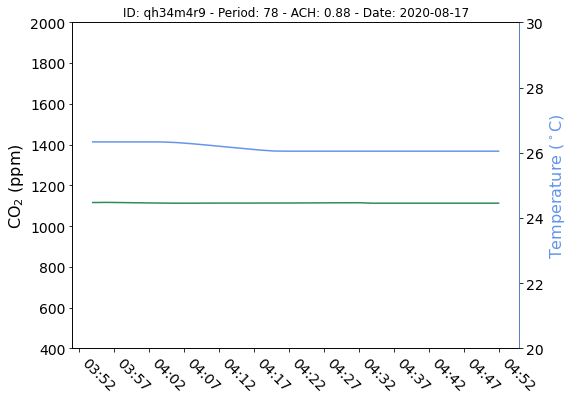

In [79]:
_ = ss_calc.diagnose_participant(19,view_ss=True)

#### Beacon 25

In [40]:
#_ = ss_calc.diagnose_participant(25,view_ss=True)

<div class="alert-block alert alert-info">
    
The CO2 concentrations are so low which does indicate that the ventilation rate is pretty good.
<div>

#### Beacon 30

In [41]:
#_ = ss_calc.diagnose_participant(30,view_ss=True)

<div class="alert-block alert alert-info">
    
While these estimates are high, I think they are fine. They don't have the same issues that the other 3 beacons have. 
<div>

#### Beacon 44

In [42]:
#_ = ss_calc.diagnose_participant(44,view_ss=True)

<div class="alert-block alert alert-info">
    
The CO2 concentrations are so low which does indicate that the ventilation rate is pretty good.
<div>

### Inspecting Occupied Steady-State Rates

In [43]:
#occupied_data_90, _ = model.get_occupied_iaq_data(confidence_threshold=0.9)
#_ = ss_calc.ventilation_ss(occupied_data_90,ss_calc.info,constant_c0=False,c0_percentile=0,min_co2_threshold=None,
                                                #data_length_threshold=6,min_window_threshold=6,min_time_threshold=600,co2_threshold_percentile=50,plot=True)

<a id="buildup_inspection"></a>

## Build-Up

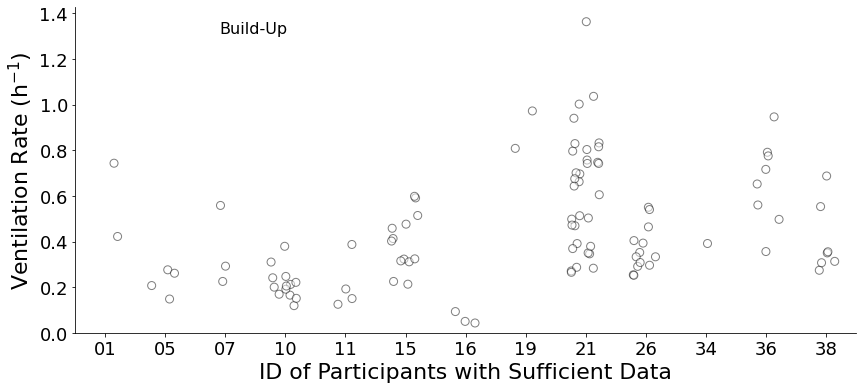

In [44]:
ventilation.plot_strip(estimates_buildup)

<div class="alert-block alert alert-success">
    
The ventilation rates seem reasonable. However, there are some pretty low estimates, especially from Beacon 16. The following cells take a closer look at the estimates.
<div>

### Investigating Participant ACH Estimates
Here we just look at a few participants to get a sense of how the estimation method is working.

#### Beacon 1
Low number of estimates but large variance

In [45]:
#_ = dynamic_calc.diagnose_participant(1,view_buildup=True)

<div class="alert-block alert alert-warning">
    
The issue with these estimates is that we are trying to fit an exponentially decaying function to what is more of a logit curve. Ideally, rather than fit the curve to the _entire_ increasing period, we would only fit to the curve when the differences between the CO2 concentrations are positive, but begin to decrease. 
<div>

#### Beacon 16
Lowest (almost zero) estimates.

Study Measurements
	Min:	2347.1869158598724
	Mean:	3451.554143313748
	Max:	4524.157187844378
Night Measurements
	Min:	3280.693202
	Mean:	4043.5730571509434
	Max:	4524.157188
Morning Measurements
	Min:	3259.0309198792875
	Mean:	3818.789924178948
	Max:	4502.938716155662


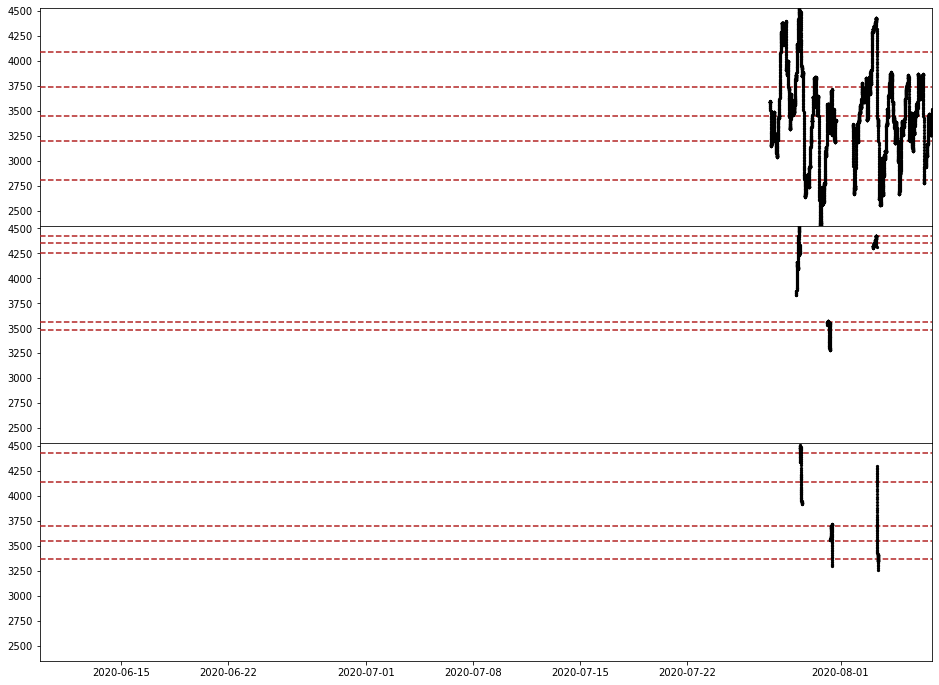

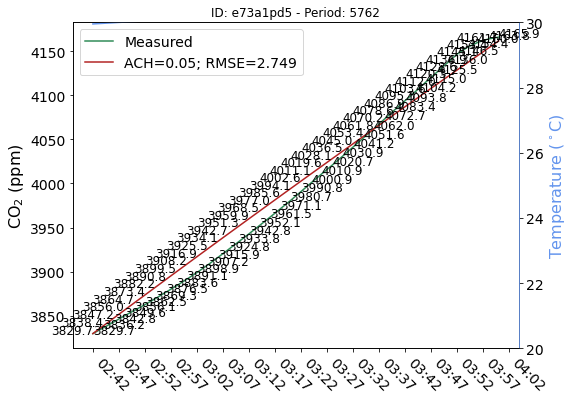

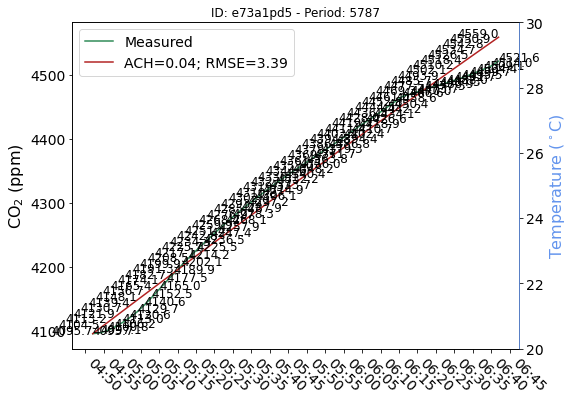

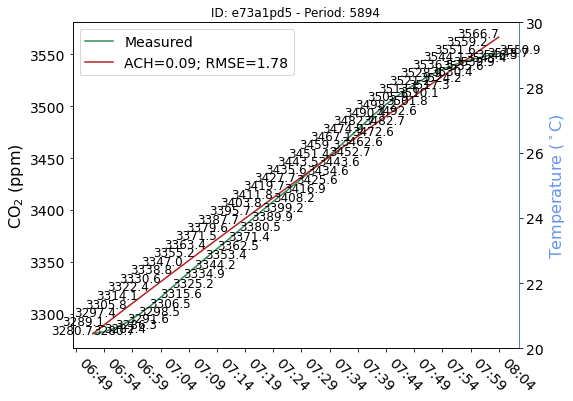

In [77]:
_ = dynamic_calc.diagnose_participant(16,view_buildup=True)

<div class="alert-block alert alert-warning">
    
The estimates from this participant seem solid but I think they could actually be improved if we considered the only the second half of each estimate. As it stands, the estimates are so low because we are essnentially fitting a linear function.
<div>

#### Beacon 21
Largest range and highest estimate

In [47]:
#_ = dynamic_calc.diagnose_participant(21,view_buildup=True)

<div class="alert-block alert alert-warning">
    
This participant illustrates a few good fits and some that again are fitting a decay to a logit curve.
<div>

### Re-Configuring Build-Up Estimation
I am not especially happy with the way the functions are fit to the measured data. A few ideas I had were:
* Look for consecutive CO2 measurements that are increasing, but the difference is decreasing between measurements.
* Remove the initial measurements from the increasing period where the differences are very low and therefore don't match the curve

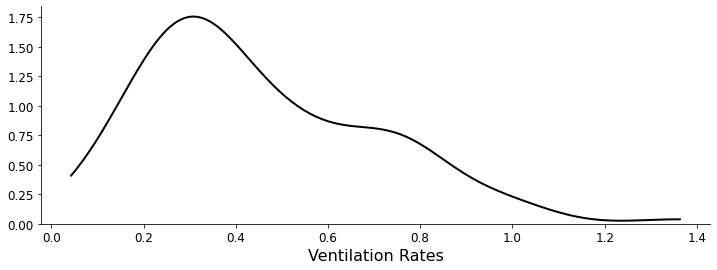

count    106.000000
mean       0.452868
std        0.251870
min        0.043000
25%        0.271750
50%        0.383000
75%        0.633500
max        1.363000
Name: ach, dtype: float64


In [48]:
dynamic_calc.summarize_estimates(estimates_buildup)

Putting this here again for reference. These data are the baseline estimates.

#### CO2 Increasing but at a Decreasing Rate
I tried this method by including a fourth option in the `get_co2_periods` method (`method="increase_decrease"`). The primary issue here was that while the concentrations _look_ like they are increasing at a decreasing rate, they don't follow that pattern for extended periods. I tried to program in a threshold, but then I got a bunch of extra values.

Another idea I had was to take a moving average or downsample the data after identifying a period and _then_ looking for the increasing periods. This would involve post-processing the co2 data from the increasing periods within the `ventilation_buildup` method.

##### Post-Processing in `ventilation_buildup`

In [49]:
#estimates_buildup_2 = dynamic_calc.ventilation_buildup(dynamic_calc.beacon_nightly, dynamic_calc.info,delta_co2_threshold=120,
#                                                          decreasing_increase=True,decreasing_increase_rate=5,
#                                                          plot=False)

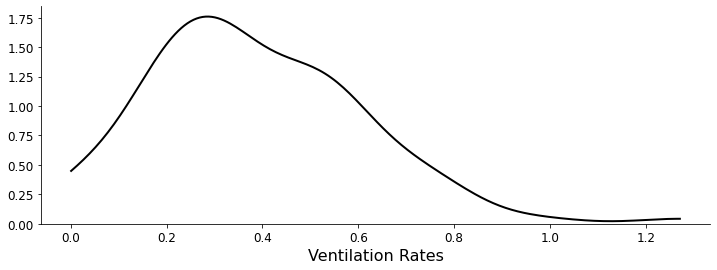

count    106.000000
mean       0.386292
std        0.225438
min        0.001000
25%        0.220250
50%        0.351000
75%        0.531500
max        1.271000
Name: ach, dtype: float64


In [50]:
#dynamic_calc.summarize_estimates(estimates_buildup_2)

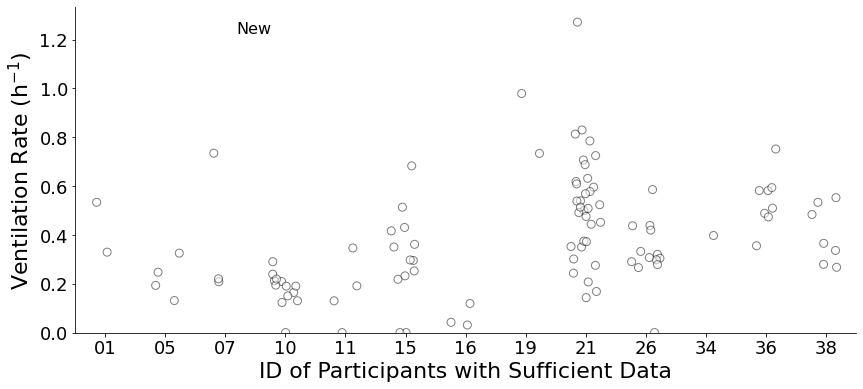

In [51]:
#estimates_buildup_2["method"] = "New"
#ventilation.plot_strip(estimates_buildup_2)

<div class="alert-block alert alert-danger">
    
The estimation method fails for a few individuals and while I was not able to debug the issue, I don't think it is merited that we continue to fall down this rabbit hole. The estimates are only _slightly_ different therefore I think keeping the original estimates is fine. 
<div>

#### Removing Initial Measurements
The primary issue we have with removing the initial measurements is _what should the threshold be?_ I explore the different thresholds below to get a sense of if this method makes sense.

We might also lose out on some of the instances where there is only small increases throughout the period which we don't want to do.

##### Threshold: 1 ppm

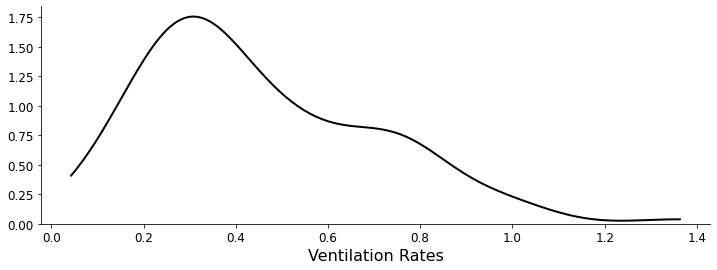

count    106.000000
mean       0.452868
std        0.251870
min        0.043000
25%        0.271750
50%        0.383000
75%        0.633500
max        1.363000
Name: ach, dtype: float64


In [52]:
#estimates_buildup_1ppm = dynamic_calc.ventilation_buildup(dynamic_calc.beacon_nightly, 
#                                                           dynamic_calc.info,delta_co2_threshold=120,
#                                                           truncate_threshold=1)
#estimates_buildup_1ppm["method"] = "1ppm"
#dynamic_calc.summarize_estimates(estimates_buildup_1ppm)

##### Threshold: 2 ppm

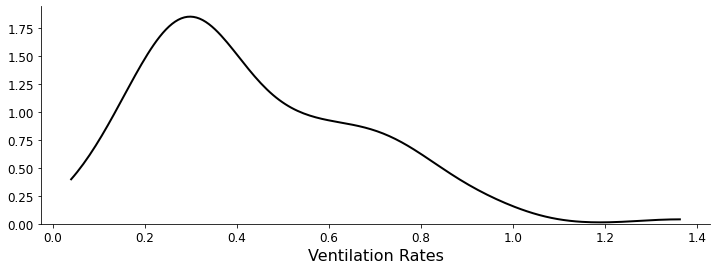

count    106.000000
mean       0.436642
std        0.240323
min        0.040000
25%        0.265000
50%        0.358000
75%        0.602750
max        1.363000
Name: ach, dtype: float64


In [53]:
#estimates_buildup_2ppm = dynamic_calc.ventilation_buildup(dynamic_calc.beacon_nightly, 
#                                                          dynamic_calc.info,delta_co2_threshold=120,
#                                                          truncate_threshold=2)
#estimates_buildup_2ppm["method"] = "2ppm"
#dynamic_calc.summarize_estimates(estimates_buildup_2ppm)

##### Threshold: 5 ppm

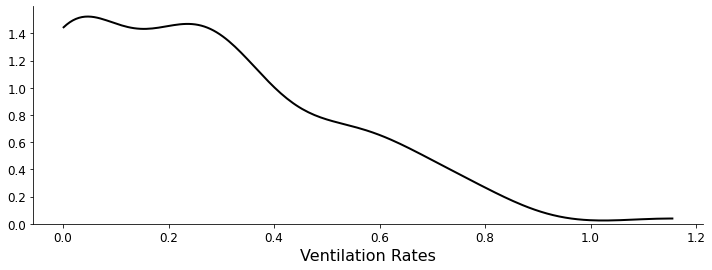

count    106.000000
mean       0.267604
std        0.247604
min        0.001000
25%        0.001000
50%        0.248000
75%        0.406750
max        1.155000
Name: ach, dtype: float64


In [54]:
#estimates_buildup_5ppm = dynamic_calc.ventilation_buildup(dynamic_calc.beacon_nightly, 
#                                                          dynamic_calc.info,delta_co2_threshold=120,
#                                                          truncate_threshold=5)
#estimates_buildup_5ppm["method"] = "5ppm"
#dynamic_calc.summarize_estimates(estimates_buildup_5ppm)

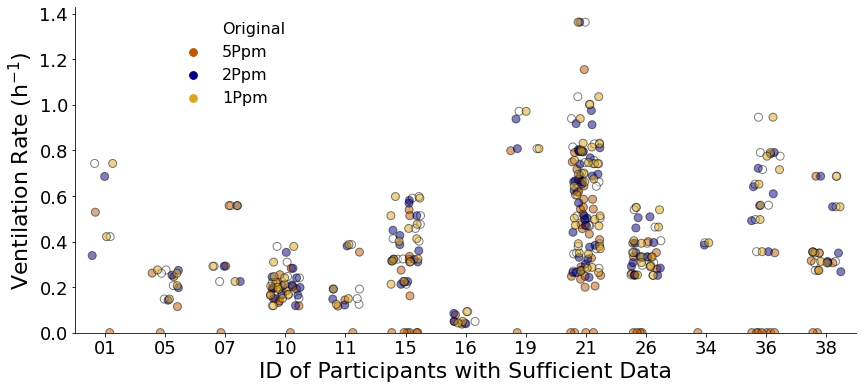

In [55]:
#estimates_og = estimates_buildup.copy()
#estimates_og["method"] = "Original"
#estimates_buildup_agg = pd.concat([estimates_og,estimates_buildup_1ppm,estimates_buildup_2ppm,estimates_buildup_5ppm])
#ventilation.plot_strip(estimates_buildup_agg)

<div class="alert-block alert alert-info">
    
Seems like including the threshold doesn't _appreciably_ affect the estimates on an aggregate basis. A threshold of 5 ppm seems too large since the estimation starts to fail for some instances.
<div>

<div class="alert-block alert alert-success">
    
I think including a 1 ppm threshold is merited since it will provide measured values that follow a function that is more similar to the estimated function.
<div>

<a id="decay_inspection"></a>

## Decay
The most accurate estimation method yet the values are still much lower than those estimated by the steady-state method so we want to look a bit closer.

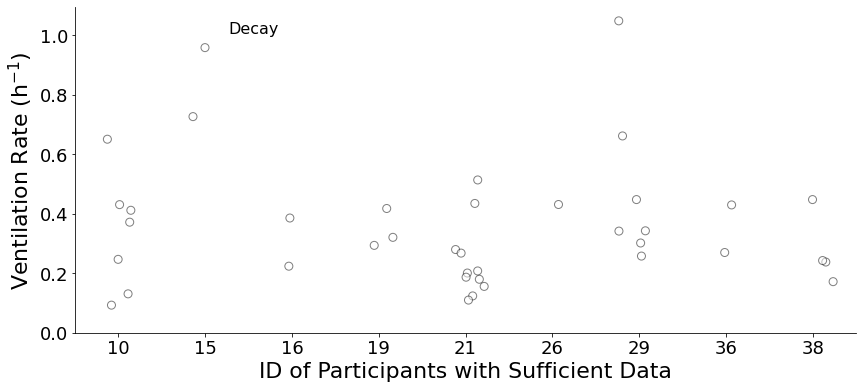

In [56]:
ventilation.plot_strip(estimates_decay)

<div class="alert-block alert alert-success">
    
These results seem solid.
<div>

### Diagnosing Results
We start by looking at the diagnostic figures which should provide some example data that we can pull and use. From there, we can do some tinkering with the inputs and assumptions to see how we can match the values/curves.

#### Beacon 10

In [57]:
#_ = dynamic_calc.diagnose_participant(10,view_decay=True)

#### Beacon 19

Study Measurements
	Min:	616.3420274524163
	Mean:	848.2671468988275
	Max:	1150.4405157349418
Night Measurements
	Min:	674.5543313
	Mean:	921.0589442741722
	Max:	1148.994606
Morning Measurements
	Min:	665.3961879310801
	Mean:	875.3272090484681
	Max:	1150.4405157349418


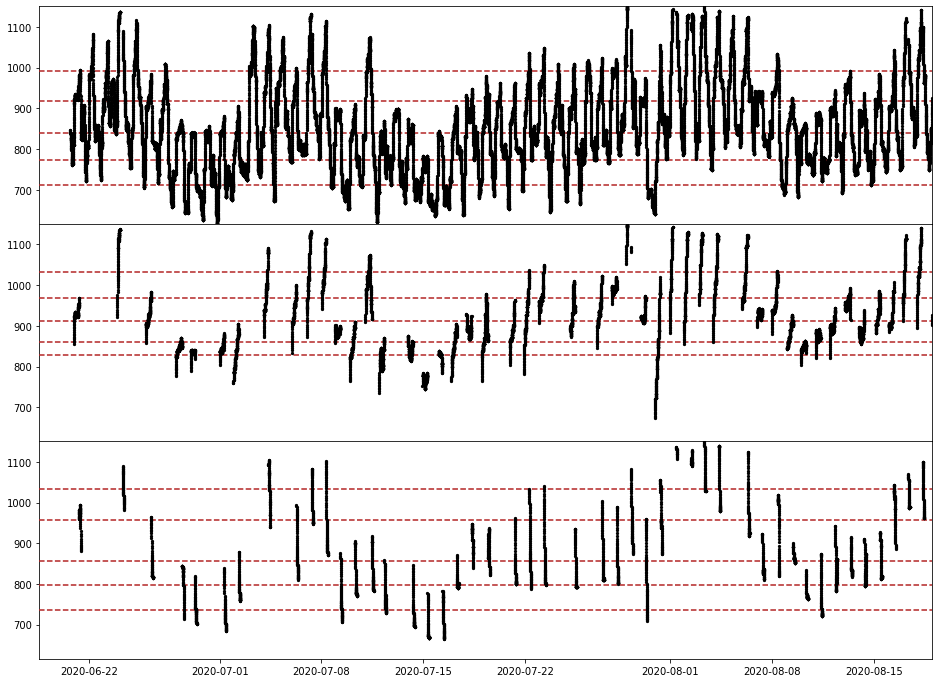

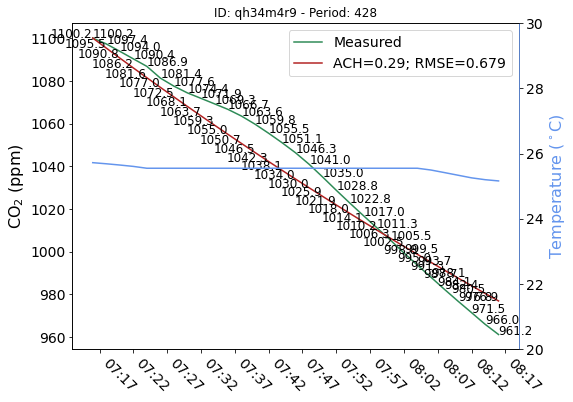

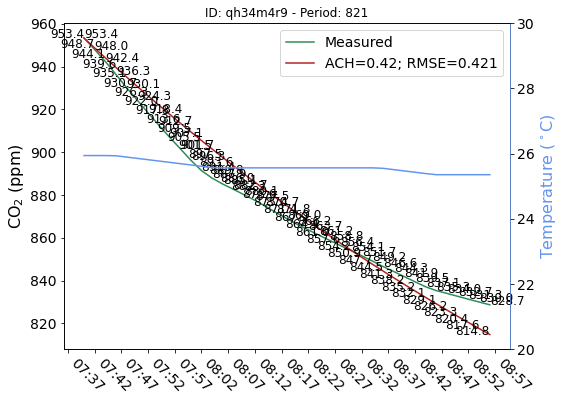

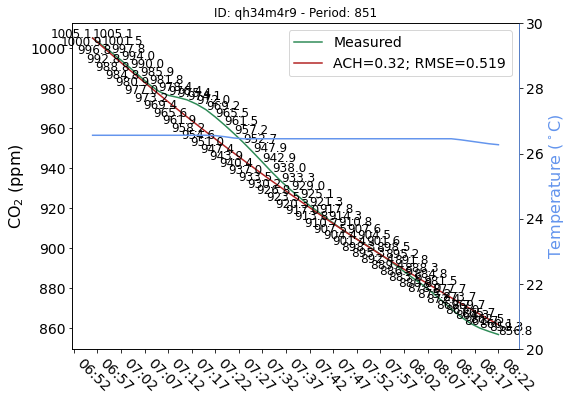

In [78]:
_ = dynamic_calc.diagnose_participant(19,view_decay=True)

#### Beacon 21

In [58]:
#_ = dynamic_calc.diagnose_participant(21,view_decay=True)

#### Beacon 29

In [59]:
#_ = dynamic_calc.diagnose_participant(29,view_decay=True)

<div class="alert-block alert alert-info">

Again we have the same issue as with the build-up approach where we are trying to get an exponential decay function to a logit curve. However, the issue is less obvious in this case. We could take some approaches similar to what we did for the build-up method and look for differences in the decreases in CO2 concentrations, but I think that would provide the same results: the estimates do not change appreciably despite the extra work we put in.
<div>

<div class="alert-block alert alert-info">

Previous analysis revealed that the background co2 assumption of 400 ppm _heavily_ influences the resulting ach. By increasing this value, the ach for _all_ beacons approaches a more realistic value. This assumption is likely the most flawed so by accounting for it, we should be able to get more reasonable results. 
<div>

---

<a id="sensitivity_analysis"></a>

[Back to ToC](#toc)
# Sensitivity Analysis
There are quite a few assumptions that are baked into the calculation and it would be interesting to see how ventilation estimates change when we vary the assumptions between _reasonable_ limits. There are three main parameters in both estimation methods that we should consider:
* $V$: volume of the bedroom
* $E$: person co2 emission rate
* $C_0$: background co2 concentration

The process will involve running the steady-state and decay (Eq 2) estimates again but varying one of the above parameters. We will determine a range of possible values for the above parameters and use a half-step approach where -1 steps would correspond to the lower limit, +1 steps would be the upper limit, and 1/2 steps would correspond to the values between the middle of the range and the lower/upper limits. 

Determining the limits is not as straight-forward as expected and depends on the parameter.

In [49]:
sa = ventilation.sensitivity_analysis(data_dir="../data")

### Volume
The limits for this parameter _are_ easy to determine. We simply need to determine reasonable values for the volume of an apartment and home bedroom.

#### Apartment
The [minimum floor area](https://buildingcodetrainer.com/minimum-bedroom-size/) for a bedroom with a single occupant is 70 ft$^2$. We can use this number along with the fact that [ceiling heights](https://www.hunker.com/12591709/what-is-the-minimum-ceiling-height-according-to-the-international-building-code) must be a minimum of 7 ft to get an _absolute_ minimum volume of **343 ft$^3$**. This value is quite small and is unlikely given the demographics of our population so, in an effort to circumvent this issue, I use the mean of this value and the default volume to get **712 ft$^3$ as the minimum $V$**. 

The maximum will be whatever volume ensures that the default value of 1080 ft$^3$ is the center of the range, meaning **1449 ft$^3$ as the maximum $V$**. 

#### House
The minimum bedroom size for a home is still the same by code, but we will increase one dimension by one foot to get **392 ft$^3$**. Using the same scheme as before, we get a **minium $V$ of 790 ft$^3$**.

In the same manner, the maximum volume is chosen to ensure that the default value is the midpoint. Therefore **1586 ft$^3$ is the maximum $V$**. 

<div class="alert-block alert alert-info">

**Apartment**: 712 - 1449
    
**Home**: 790 - 1586
<div>

### Emission Rate
These limits are a bit trickier to estimate. The equation we are using for the emission rate, shown [above](#emission_rate_discussion), depends on a few variables. In the points below, we highlight the process we will use to determine limits on emission rate:
* $T$: we can use the minimum and maximum temperature measured during the evenings for the range of possible temperatures. _$T$ is directly related to $E$_.
* $P$: while there are likely variations in pressure depending on the location, I think it is safe to assume a constant $P$ - **we will hold $P$ constant**. 
* $BMR$: BMR is dependent on the mass and sex of the individual. I think we are safe to use the minimum and maximum mass per sex to establish a limit on the mass for each sex and therefore BMR. _$BMR$ is directly related to $E$_.
* $M$: the activity level measured as METs should be held constant since we are safe to assume the participant is asleep - **we will hold $M$ constant**. 

#### Temperature

In [10]:
min_t = np.nanmin(sa.beacon_nightly["temperature_c"])
max_t = np.nanmax(sa.beacon_nightly["temperature_c"])
print(f"Min:\t{min_t}\nMax:\t{max_t}")

Min:	15.38867915
Max:	33.13683188


#### BMR

In [11]:
sa.info[["sex","mass","bmr"]].groupby(["sex"]).min()

,mass,bmr
sex,,
Female,47.173568,4.960761
Male,58.962424,6.610633


In [12]:
sa.info[["sex","mass","bmr"]].groupby(["sex"]).max()

,mass,bmr
sex,,
Female,80.720737,7.040686
Male,83.914520,8.182615


#### Rate


In [13]:
min_e_f = sa.get_emission_rate(BMR=4.96,T=15.4+273.15)*3600
max_e_f = sa.get_emission_rate(BMR=7.04,T=33.1+273.15)*3600
min_e_m = sa.get_emission_rate(BMR=6.61,T=15.4+273.15)*3600
max_e_m = sa.get_emission_rate(BMR=8.18,T=33.1+273.15)*3600
print(f"Female:\n\tMin\t{min_e_f}\n\tMax\t{max_e_f}\nMale:\n\tMin\t{min_e_m}\n\tMax\t{max_e_m}")

Female:
	Min	8.547872326243901
	Max	12.876683707317072
Male:
	Min	11.391418563804875
	Max	14.961828512195119


<div class="alert-block alert alert-info">

**Female**: 0.0023744089795121946 - 0.0035768565853658532
    
**Male**: 0.0031642829343902427 - 0.004156063475609755
<div>

### Background CO$_2$ Concentration
We have already seen how important this variable is in the above analysis with the decay esimate. While, on the surface, this variable seems easy to manipulate, there are two configurations I want to investigate:
1. **Vary CO$_2$ within constant limit**: Just like with $V$, we will determine a reasonable range of background CO$_2$ and apply it across _all_ participants. 
2. **Vary CO$_2$ within participant-based limit**: We will use percentiles of CO$_2$ measurements specific to each participant to determine a range of background concentrations.

<div class="alert-block alert alert-info">

**Constant**: 400 - 500
    
**Participant-Based**: 0th percentile (minimum) - 10th percentile
<div>

<a id="ss_sa"></a>

## Steady-State Estimates

### One-Way SA

In [69]:
res_sa_ss = ss_calc.run_sensitivity_analysis(method="ss",params=["e","v","c0"],steps=[0,0.25,0.75,1],constant_c0=False,verbose=False)

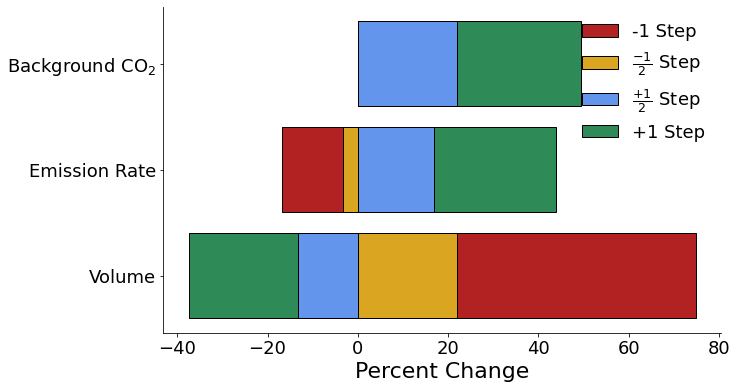

In [70]:
sa_ss_summary = ss_calc.compare_sa_to_base(res_sa_ss,estimates_ss,steps=[0,0.25,0.75,1],plot=True)

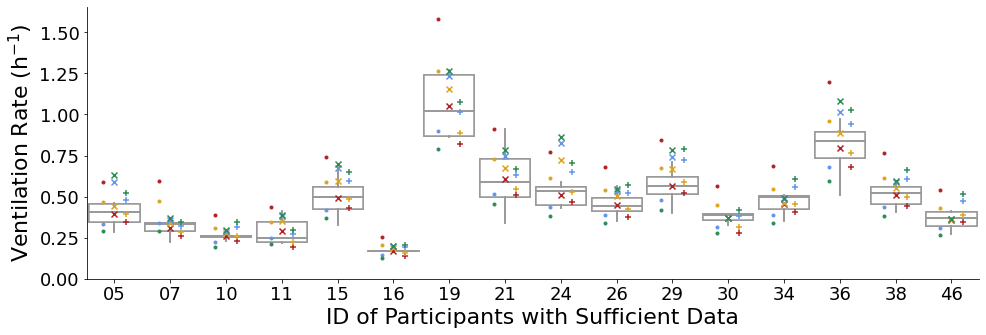

In [71]:
ss_calc.compare_sa_to_base_pt_v2(res_sa_ss,estimates_ss,beacons_to_exclude=[1,25,44],save=False)

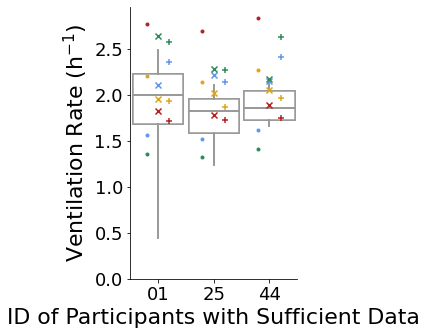

In [72]:
ss_calc.compare_sa_to_base_pt_v2(res_sa_ss,estimates_ss,
                beacons_to_exclude=[beacon for beacon in res_sa_ss["beacon"].unique() if beacon not in [1,25,44]],
                save=False,annot="-high_rates")

In [73]:
sa_ss_summary

,0,0.25,0.75,1
parameter,,,,
v,52.97,21.94,-13.26,-24.20
e,-13.40,-3.31,16.88,26.97
c0,0.00,12.13,22.06,27.32


<div class="alert-block alert alert-info">

The volume seems to have the greatest effect on the ventilation estimates although we are taking ranges that are outside the dataset. Higher emission rates also tended to have a more pronounced effect on the ventilation rate. 
<div>

### Global SA - Sobol Indices

In [46]:
res = ss_calc.sobol(estimates_ss)

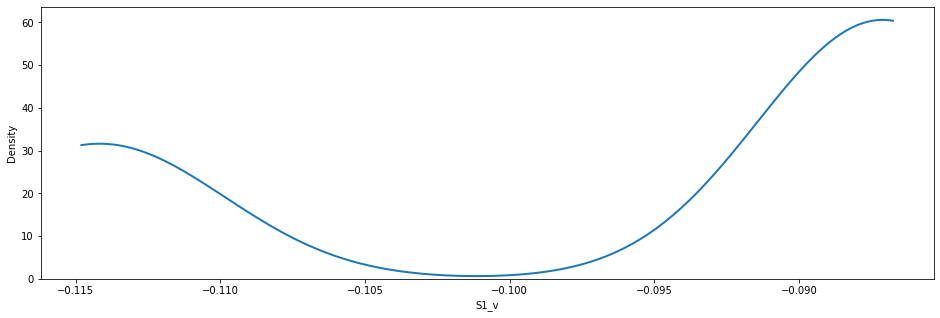

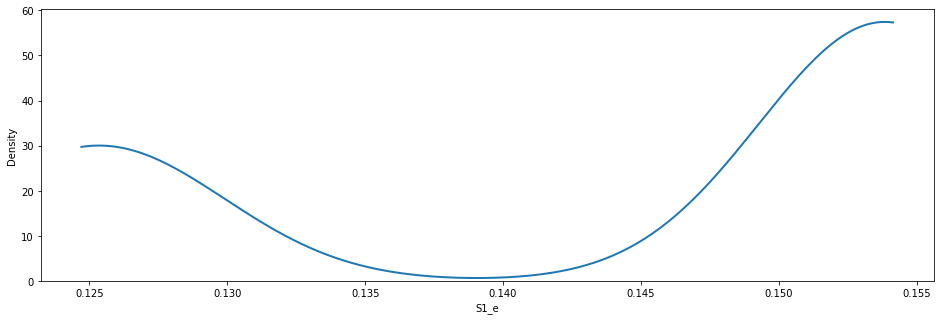

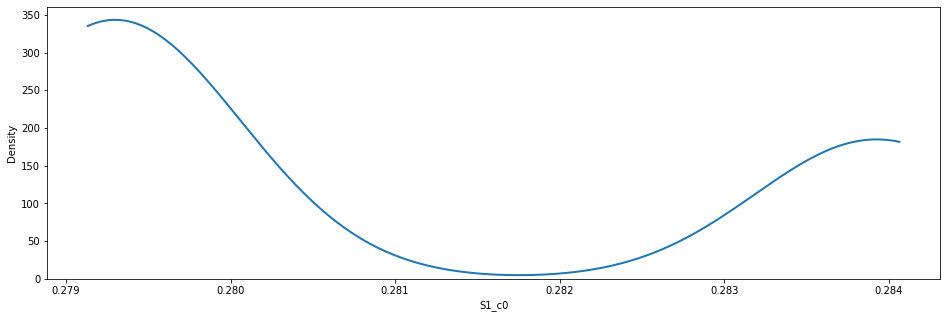

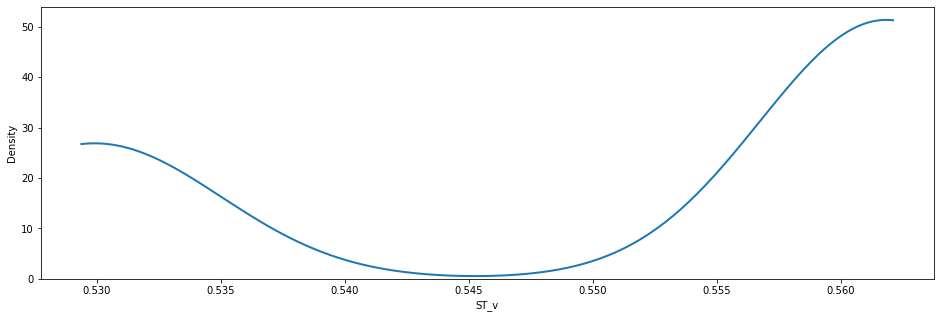

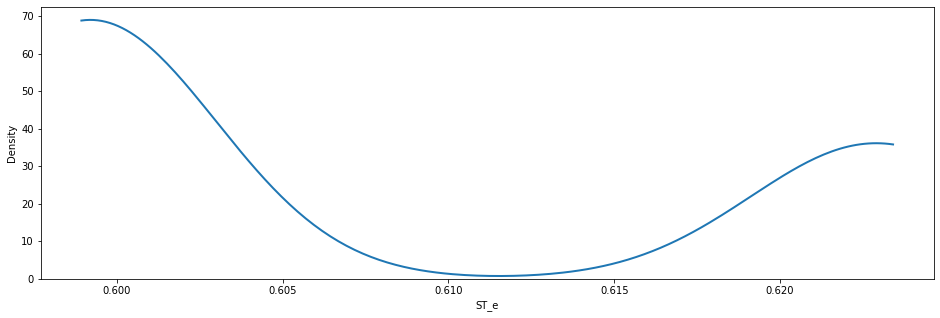

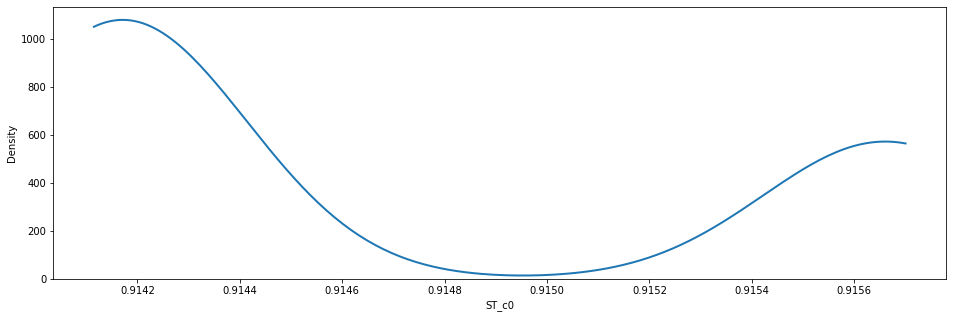

In [48]:
for param in res.columns:
    if param not in ["C","beacon"]:
        _, ax = plt.subplots(figsize=(16,5))
        sns.kdeplot(res[param],cut=0,lw=2)
        
        plt.show()
        plt.close()

<a id="buildup_sa"></a>

## Build-Up Estimates

In [74]:
res_sa_buildup = dynamic_calc.run_sensitivity_analysis(method="buildup",params=["c0"],steps=[0,0.25,0.75,1],constant_c0=False,verbose=True)
sa_buildup_summary = dynamic_calc.compare_sa_to_base(res_sa_decay,estimates_decay,steps=[0,0.25,0.75,1],plot=True)
sa_buildup_summary

Participant nvtfpaor
	Home
	Female
	Param: c0


TypeError: ventilation_buildup() got an unexpected keyword argument 'c0'

<a id="decay_sa"></a>

## Decay Estimates

In [ ]:
res_sa_decay = dynamic_calc.run_sensitivity_analysis(method="decay",params=["c0"],steps=[0,0.25,0.75,1],constant_c0=False,verbose=True)
sa_decay_summary = dynamic_calc.compare_sa_to_base(res_sa_decay,estimates_decay,steps=[0,0.25,0.75,1],plot=True)
sa_decay_summary

[Back to Top](#inspecting)

---

<a id="summary"></a>

[Back to ToC](#toc)
# Some Summary
General summary of the data to use for the paper.

## Number of IAQ measurements
I guess we should combine the number of datapoints from the nightly dataframe and the morning dataframe.

In [ ]:
print(f"Number of Data Points:", len(ss_calc.beacon_nightly) + len(dynamic_calc.beacon_morning))

## Summary Stats

### All Estimates

## Number of Available Periods

In [ ]:
# setting up results
percents = [0.7,0.8,0.9]
res = {p: [] for p in percents}
res["beacon"] = []
res["n"] = []

# Number from Data Fusion
base = ss_calc.beacon_nightly.groupby(["beacon","start_time"]).mean().reset_index()
# Number from Occupancy

# looping through all combinations
for bb in base["beacon"].unique():
    res["beacon"].append(str(bb))
    n_base = len(base[base['beacon'] == bb])
    res["n"].append(n_base)
    bw = ss_calc.info[ss_calc.info["beacon"] == bb].index.values[0]
    for p in percents:
        _, n_extra = model.get_occupied_iaq_data(confidence_threshold=p)
        res[p].append(len(n_extra[n_extra["beiwe"] == bw])+n_base)

In [ ]:
_, ax = plt.subplots(figsize=(12,6))
df = pd.DataFrame(res)
df.sort_values("n",ascending=False,inplace=True)
ax.scatter(df["beacon"],df["n"],color="black",s=50,label="Data Fusion Only (Base)",zorder=10)
for p in percents:
    ax.scatter(df["beacon"],df[p],s=75,label=f"Base + Above {int(p*100)}%",zorder=1)
# x-axis
ax.set_xlabel("Participant",fontsize=20)
# y-axis
ax.set_ylabel("Number of Periods",fontsize=20)
# remainder
ax.tick_params(labelsize=16)
for loc in ["top","right"]:
    ax.spines[loc].set_visible(False)
ax.legend(frameon=False,fontsize=18)
    
plt.savefig("../reports/figures/beacon_fitbit/beacon_fitbit_available_nights.pdf",bbox_inches="tight")
plt.show()
plt.close()

In [ ]:
np.sum(df["n"])

## SA Step Values

In [89]:
def print_sa_param_steps(limit, steps=[0,25,50,75,100],for_latex=False):
    """
    Prints the key values for the given limit
    """
    if for_latex:
        ending = " & "
        final_ending = " \\\\"
    else:
        ending = " "
        final_ending = " "
    for step in steps:
        if step == 100:
            print(round(np.percentile(limit,step),1),end=final_ending)
        else:
            print(round(np.percentile(limit,step),1),end=ending)

### Background CO2
Just the percentile values

In [79]:
print_sa_param_steps([0,4],for_latex=False)

0.0 1.0 2.0 3.0 4.0 

### Volume
Different for Apartment or House (in ft$^3$)

In [83]:
print("Apartment")
print_sa_param_steps([712,1448],for_latex=True)

print("\nHouse")
print_sa_param_steps([790,1586],for_latex=True)

Apartment
712.0 & 896.0 & 1080.0 & 1264.0 & 1448.0 \\
House
790.0 & 989.0 & 1188.0 & 1387.0 & 1586.0 \\

### Emission Rate
Different for male versus female (in L/h)

In [90]:
print("Male")
print_sa_param_steps([0.0031642829343902427*3600, 0.004059001845141127*3600],for_latex=True)

print("\nFemale")
print_sa_param_steps([0.0023744089795121946*3600, 0.003051852397205989*3600],for_latex=True)

Male
11.4 & 12.2 & 13.0 & 13.8 & 14.6 \\
Female
8.5 & 9.2 & 9.8 & 10.4 & 11.0 \\

---